At time  0


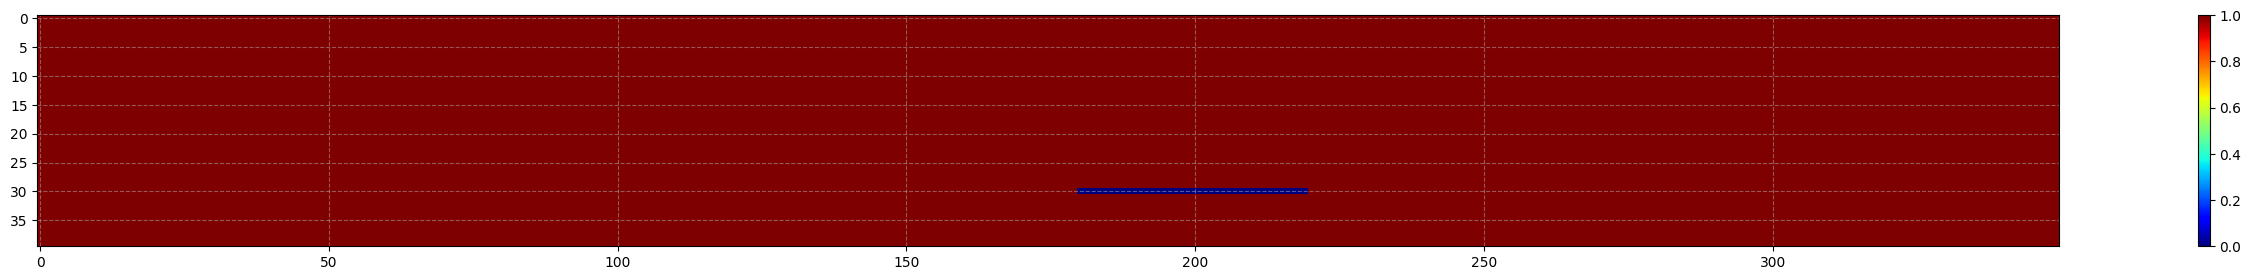

At time  2250


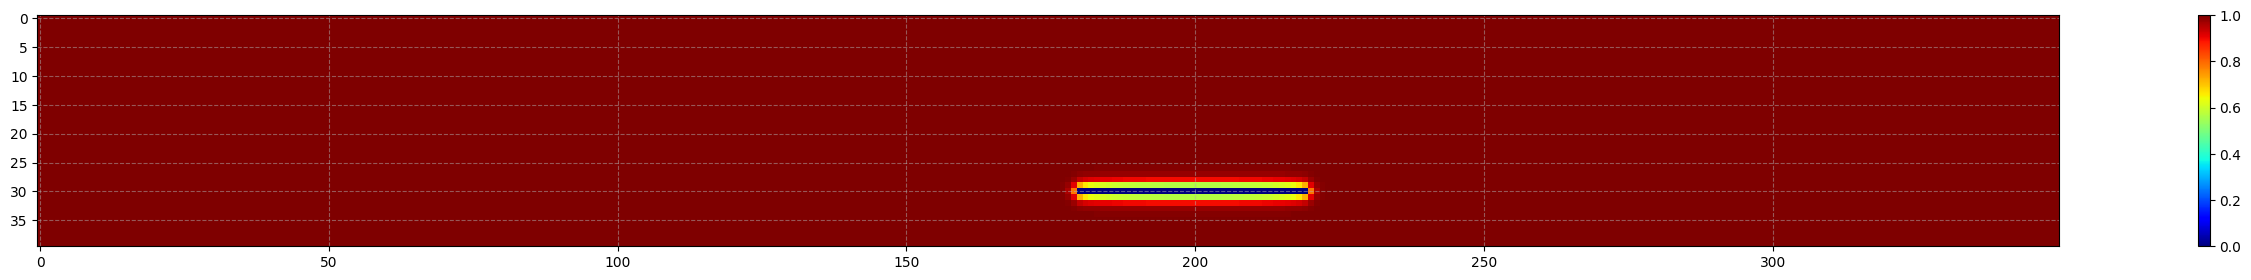

At time  4500


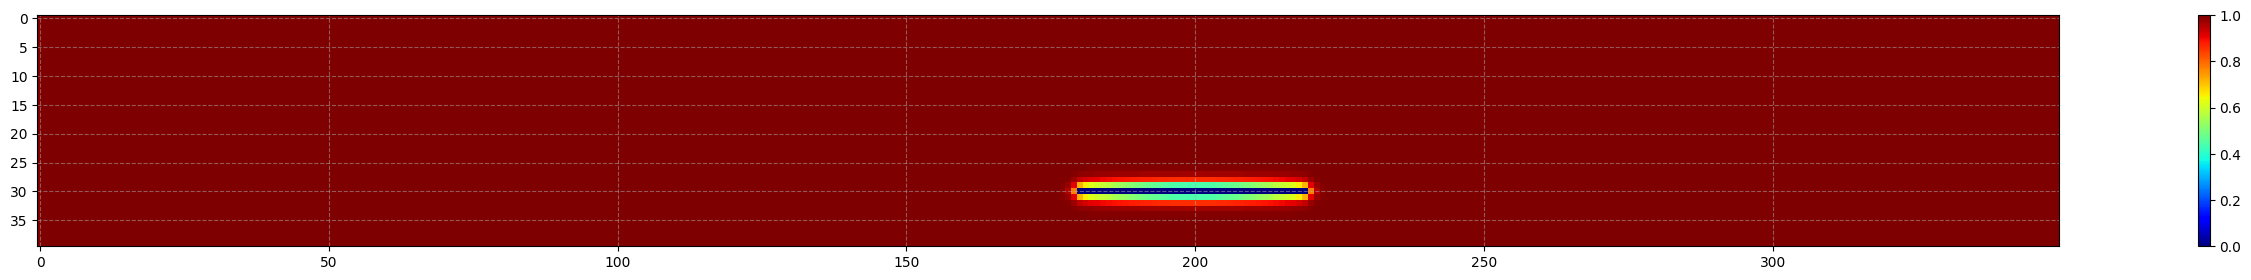

At time  6800


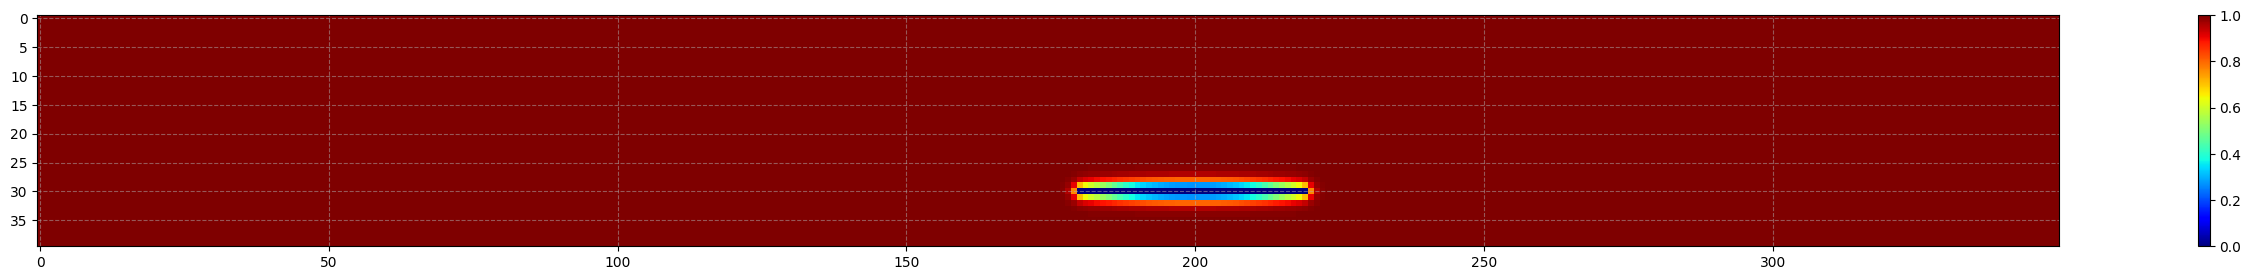

At time  9090


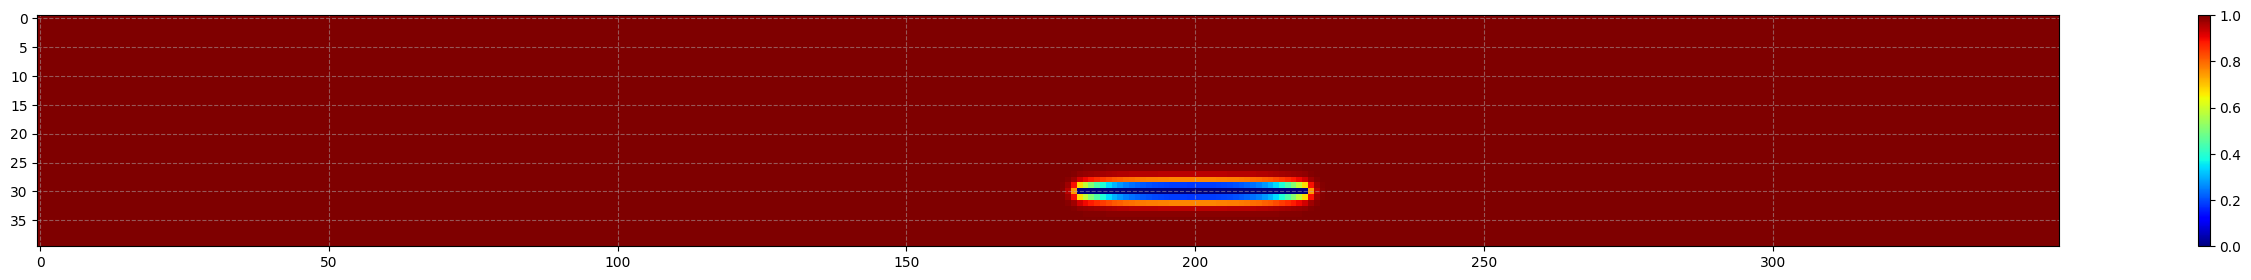

At time  11362


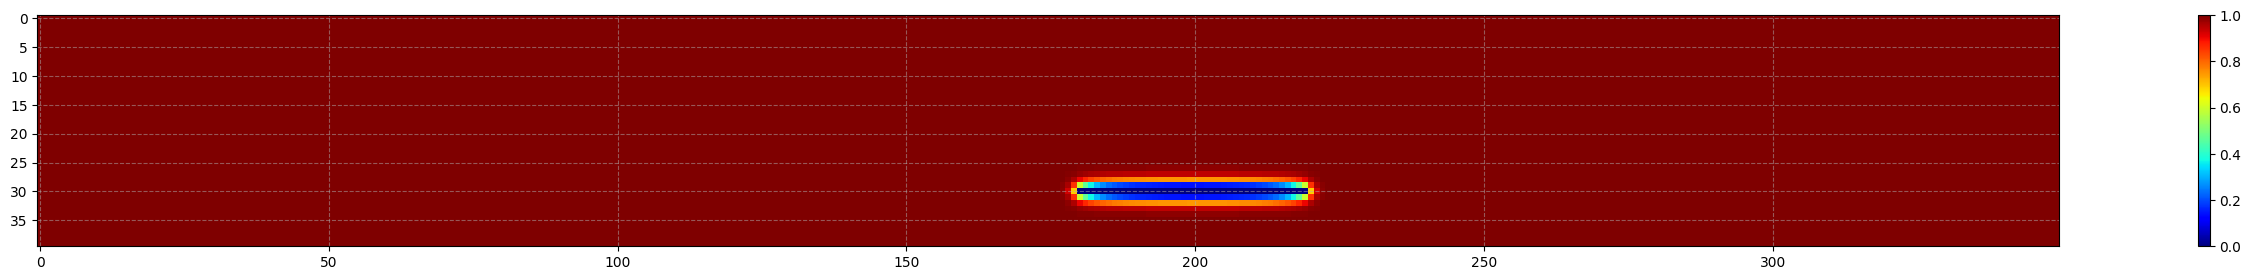

At time  13635


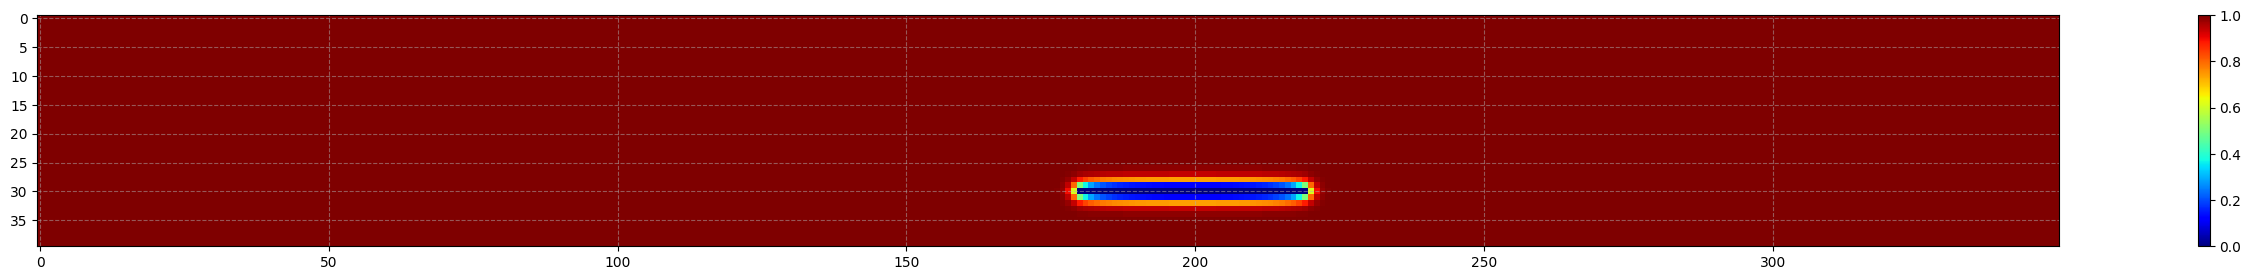

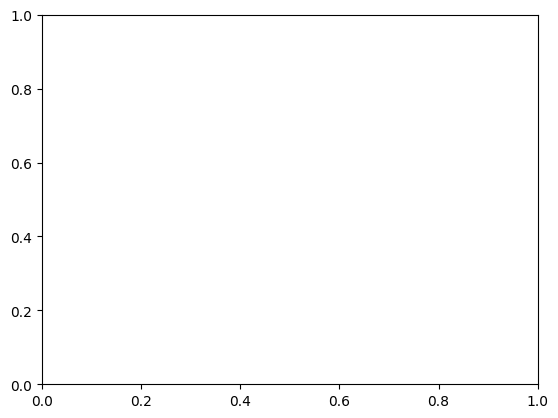

Total runtime of the module is 117.89308952093124 minutes


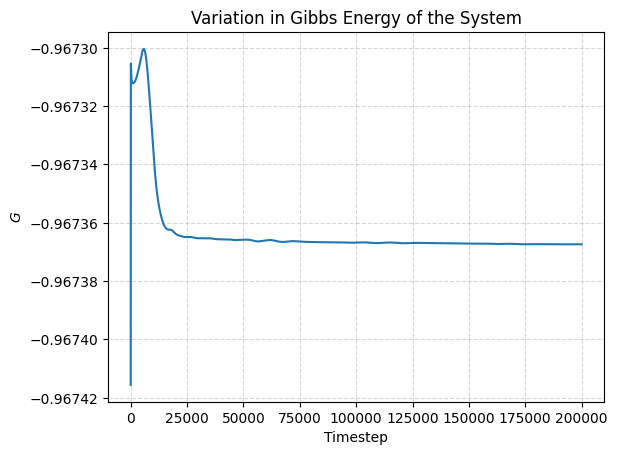

In [2]:
#To measure the time taken to execute
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation #Added for the purpose of animation
from IPython.display import HTML #Added for the purpose of animation

import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
%matplotlib inline

# store starting time
begin = time.time()

#Storing the number of nodes in X and Y direction
Nx = 901
Ny = 301
X , Y = np.meshgrid(range(Nx),range(Ny))

phi = np.ones((Ny,Nx))
l = 40 #length of the crack
fracstrain = 0.866025404 #This is the thoeretical value of strain that will be required to nucleate crack in a intact body
initstrain = 0.1803*fracstrain#0.1803*fracstrain
phi[int((Ny-1)/2.),(int((Nx-1)/2.- l/2.)): (int((Nx-1)/2. + l/2.))] = 0.#The initial crack

# for i in range(Ny):
#     for j in range(Nx):
#         if ((X[150,j] - X[150,450])**2 + (Y[i,450]-Y[150,450])**2) <= (l/2)**2:
#             phi[i,j] = 0.

disp1 = np.zeros((Ny,Nx))
disp2 = np.zeros((Ny,Nx))
vel_1 = np.zeros((Ny,Nx))
vel_2 = np.zeros((Ny,Nx))
acc_1 = np.zeros((Ny,Nx))
acc_2 = np.zeros((Ny,Nx))

strain = np.zeros((2,2,Ny,Nx))
stress = np.zeros((2,2,Ny,Nx))
delta_chi_1 = 1
delta_chi_2 = 1
G_sum=np.zeros((Ny,Nx))
Eavg_Eth = np.zeros((Ny,Nx))
Area = (Nx-1)*(Ny-1)

tsteps = 200000
nprint = 500
K_prime = 4
rho_prime = 1
eta_prime = 2
lambda_eth = 1.0 
mu_eth = 1.0 
dt = 0.01
phi_new = np.zeros((Ny,Nx))
a1_new = np.zeros((Ny,Nx))
a2_new = np.zeros((Ny,Nx))
Postprocess = np.zeros((tsteps,2)) #This is to store values of Gibbs Energy at each time step
lap_phi = np.zeros((Ny,Nx))
dstressdx1 = np.zeros((Ny,Nx))
dstressdx2 = np.zeros((Ny,Nx))
lap_vel1 = np.zeros((Ny,Nx))
lap_vel2 = np.zeros((Ny,Nx))
phi_animate = np.zeros((Ny,Nx,int(tsteps/nprint)))
p=0
for t in range(tsteps):
    #Calculate updated value of Displacements as pper Velocity Verlet Algorithm
    disp1 += vel_1*dt + 0.5 * acc_1 * dt**2
    disp2 += vel_2*dt + 0.5 * acc_2 * dt**2
    
    g_phi = 4*phi**3 - 3*phi**4 #This needs to be computed at each time step
    gprime_phi = 12.0*phi**2 - 12.0*phi**3#This needs to be computed at each timestep
    
    if t==2250 or t==4500 or t==6800 or t==0 or t==9090 or t==11362 or t==13635:
        print(f"At time ",t)
        plt.figure(figsize=(36,3))
        plt.imshow(phi[120:160,250:600],cmap='jet')
        plt.colorbar()
        plt.grid('on',linestyle='--',alpha=0.5)
        plt.show()
    
    #Computation of Strains with periodic BCs
    strain[0,0,:,1:Nx-2] = (disp1[:,2:Nx-1] - disp1[:,0:Nx-3])/(2*delta_chi_1)
    strain[0,0,:,0] = (disp1[:,1] - disp1[:,Nx-1])/(2*delta_chi_1)
    strain[0,0,:,Nx-2] = (disp1[:,Nx-1] - disp1[:,Nx-3])/(2*delta_chi_1)
    strain[0,0,:,Nx-1] = (disp1[:,0] - disp1[:,Nx-2])/(2*delta_chi_1)
    
    strain[0,1,1:Ny-2,1:Nx-2] = 0.5 * ((disp1[2:Ny-1,1:Nx-2] - disp1[0:Ny-3,1:Nx-2])/(2*delta_chi_2)\
                                  + (disp2[1:Ny-2,2:Nx-1] - disp2[1:Ny-2,0:Nx-3])/(2*delta_chi_1))
    strain[0,1,1:Ny-2,Nx-2] = 0.5 * ((disp1[2:Ny-1,Nx-2] - disp1[0:Ny-3,Nx-2])/(2*delta_chi_2)\
                                  + (disp2[1:Ny-2,Nx-1] - disp2[1:Ny-2,Nx-3])/(2*delta_chi_1))
    strain[0,1,Ny-2,1:Nx-2] = 0.5 * ((disp1[Ny-1,1:Nx-2] - disp1[Ny-3,1:Nx-2])/(2*delta_chi_2)\
                                  + (disp2[Ny-2,2:Nx-1] - disp2[Ny-2,0:Nx-3])/(2*delta_chi_1))
    strain[0,1,0,1:Nx-2] = 0.5 * ((disp1[1,1:Nx-2] - disp1[Ny-1,1:Nx-2])/(2*delta_chi_2)\
                                  + (disp2[0,2:Nx-1] - disp2[0,0:Nx-3])/(2*delta_chi_1))
    strain[0,1,1:Ny-2,Nx-1] = 0.5 * ((disp1[2:Ny-1,Nx-1] - disp1[0:Ny-3,Nx-1])/(2*delta_chi_2)\
                                  + (disp2[1:Ny-2,0] - disp2[1:Ny-2,Nx-2])/(2*delta_chi_1))
    strain[0,1,Ny-1,1:Nx-2] = 0.5 * ((disp1[0,1:Nx-2] - disp1[Ny-2,1:Nx-2])/(2*delta_chi_2)\
                                  + (disp2[Ny-1,2:Nx-1] - disp2[Ny-1,0:Nx-3])/(2*delta_chi_1))
    strain[0,1,1:Ny-2,0] = 0.5 * ((disp1[2:Ny-1,0] - disp1[0:Ny-3,0])/(2*delta_chi_2)\
                                  + (disp2[1:Ny-2,1] - disp2[1:Ny-2,Nx-1])/(2*delta_chi_1))
    strain[0,1,Ny-1,Nx-2] = 0.5 * ((disp1[0,Nx-2] - disp1[Ny-2,Nx-2])/(2*delta_chi_2)\
                                  + (disp2[Ny-1,Nx-1] - disp2[Ny-1,Nx-3])/(2*delta_chi_1))
    strain[0,1,Ny-2,0] = 0.5 * ((disp1[Ny-1,0] - disp1[Ny-3,0])/(2*delta_chi_2)\
                                  + (disp2[Ny-2,1] - disp2[Ny-2,Nx-1])/(2*delta_chi_1))
    strain[0,1,Ny-2,Nx-2] = 0.5 * ((disp1[Ny-1,Nx-2] - disp1[Ny-3,Nx-2])/(2*delta_chi_2)\
                                  + (disp2[Ny-2,Nx-1] - disp2[Ny-2,Nx-3])/(2*delta_chi_1))
    strain[0,1,Ny-2,Nx-1] = 0.5 * ((disp1[Ny-1,Nx-1] - disp1[Ny-3,Nx-1])/(2*delta_chi_2)\
                                  + (disp2[Ny-2,0] - disp2[Ny-2,Nx-2])/(2*delta_chi_1))
    strain[0,1,0,Nx-2] = 0.5 * ((disp1[1,Nx-2] - disp1[Ny-1,Nx-2])/(2*delta_chi_2)\
                                  + (disp2[0,Nx-1] - disp2[0,Nx-3])/(2*delta_chi_1))
    strain[0,1,0,0] = 0.5 * ((disp1[1,0] - disp1[Ny-1,0])/(2*delta_chi_2)\
                                  + (disp2[0,1] - disp2[0,Nx-1])/(2*delta_chi_1))
    strain[0,1,0,Nx-1] = 0.5 * ((disp1[1,Nx-1] - disp1[Ny-1,Nx-1])/(2*delta_chi_2)\
                                  + (disp2[0,0] - disp2[0,Nx-2])/(2*delta_chi_1))
    strain[0,1,Ny-1,Nx-1] = 0.5 * ((disp1[0,Nx-1] - disp1[Ny-2,Nx-1])/(2*delta_chi_2)\
                                  + (disp2[Ny-1,0] - disp2[Ny-1,Nx-2])/(2*delta_chi_1))
    strain[0,1,Ny-1,0] = 0.5 * ((disp1[0,0] - disp1[Ny-2,0])/(2*delta_chi_2)\
                                  + (disp2[Ny-1,1] - disp2[Ny-1,Nx-1])/(2*delta_chi_1))
    strain[1,0,...] = strain[0,1,...]

    strain[1,1,1:Ny-2,:] = (initstrain + (disp2[2:Ny-1,:] - disp2[0:Ny-3,:])/(2*delta_chi_2))
    strain[1,1,0,:] = (initstrain + (disp2[1,:] - disp2[Ny-1,:])/(2*delta_chi_2))
    strain[1,1,Ny-2,:] = (initstrain + (disp2[Ny-1,:] - disp2[Ny-3,:])/(2*delta_chi_2))
    strain[1,1,Ny-1,:] = (initstrain + (disp2[0,:] - disp2[Ny-2,:])/(2*delta_chi_2))
    
    
    #Computation of Stress Tensor
    stress[0,0,...] = (lambda_eth +2.*mu_eth)*strain[0,0,...]*g_phi
    stress[0,1,...] = mu_eth * 2. * strain[0,1,...] *g_phi
    stress[1,0,...] = stress[0,1,...]
    stress[1,1,...] = (lambda_eth + 2. * mu_eth)* strain[1,1,...] * g_phi
    
    #Computation of Elastic Energy
    Eelas_eth = lambda_eth * ((strain[0,0,...]**2)/2. + (strain[1,1,...]**2)/2.) + \
                                 mu_eth * (strain[0,0,...]**2 + strain[1,1,...]**2 +\
                                 strain[0,1,...]**2 + strain[1,0,...]**2)
    
    #phi[np.where(Eelas_eth > 1)] = 0. #Material Failure Criteria
    Eavg_Eth = Eelas_eth * g_phi
    
    #Computation of Gibbs Energy with Periodic Boundaries
    G_sum[1:(Ny-2),1:(Nx-2)] = g_phi[1:Ny-2,1:Nx-2]*(Eelas_eth[1:Ny-2,1:Nx-2] - 1) + 2.*(((phi[1:Ny-2,2:Nx-1] - phi[1:Ny-2,0:Nx-3])/2*delta_chi_1)**2+((phi[2:Ny-1,1:Nx-2]-phi[0:Ny-3,1:Nx-2])/2*delta_chi_2)**2)
    G_sum[1:(Ny-2),Nx-2] = g_phi[1:Ny-2,Nx-2]*(Eelas_eth[1:Ny-2,Nx-2] - 1) + 2.*(((phi[1:Ny-2,Nx-1] - phi[1:Ny-2,Nx-3])/2*delta_chi_1)**2+((phi[2:Ny-1,Nx-2]-phi[0:Ny-3,Nx-2])/2*delta_chi_2)**2) 
    G_sum[Ny-2,1:(Nx-2)] = g_phi[Ny-2,1:Nx-2]*(Eelas_eth[Ny-2,1:Nx-2] - 1) + 2.*(((phi[Ny-2,2:Nx-1] - phi[Ny-2,0:Nx-3])/2*delta_chi_1)**2+((phi[Ny-1,1:Nx-2]-phi[Ny-3,1:Nx-2])/2*delta_chi_2)**2)  
    G_sum[0,1:(Nx-2)] = g_phi[0,1:Nx-2]*(Eelas_eth[0,1:Nx-2] - 1) + 2.*(((phi[0,2:Nx-1] - phi[0,0:Nx-3])/2*delta_chi_1)**2+((phi[1,1:Nx-2]-phi[Ny-1,1:Nx-2])/2*delta_chi_2)**2)  
    G_sum[1:(Ny-2),Nx-1] = g_phi[1:Ny-2,Nx-1]*(Eelas_eth[1:Ny-2,Nx-1] - 1) + 2.*(((phi[1:Ny-2,0] - phi[1:Ny-2,Nx-2])/2*delta_chi_1)**2+((phi[2:Ny-1,Nx-1]-phi[0:Ny-3,Nx-1])/2*delta_chi_2)**2)
    G_sum[Ny-1,1:(Nx-2)] = g_phi[Ny-1,1:Nx-2]*(Eelas_eth[Ny-1,1:Nx-2] - 1) + 2.*(((phi[Ny-1,2:Nx-1] - phi[Ny-1,0:Nx-3])/2*delta_chi_1)**2+((phi[0,1:Nx-2]-phi[Ny-2,1:Nx-2])/2*delta_chi_2)**2)  
    G_sum[1:(Ny-2),0] = g_phi[1:Ny-2,0]*(Eelas_eth[1:Ny-2,0] - 1) + 2.*(((phi[1:Ny-2,1] - phi[1:Ny-2,Nx-1])/2*delta_chi_1)**2+((phi[2:Ny-1,0]-phi[0:Ny-3,0])/2*delta_chi_2)**2)
    G_sum[(Ny-1),(Nx-2)] = g_phi[Ny-1,Nx-2]*(Eelas_eth[Ny-1,Nx-2] - 1) + 2.*(((phi[Ny-1,Nx-1] - phi[Ny-1,Nx-3])/2*delta_chi_1)**2+((phi[0,Nx-2]-phi[Ny-2,Nx-2])/2*delta_chi_2)**2)
    G_sum[Ny-2,0] = g_phi[Ny-2,0]*(Eelas_eth[Ny-2,0] - 1) + 2.*(((phi[Ny-2,1] - phi[Ny-2,Nx-1])/2*delta_chi_1)**2+((phi[Ny-1,0]-phi[Ny-3,0])/2*delta_chi_2)**2)
    G_sum[Ny-2,Nx-2] = g_phi[Ny-2,Nx-2]*(Eelas_eth[Ny-2,Nx-2] - 1) + 2.*(((phi[Ny-2,Nx-1] - phi[Ny-2,Nx-3])/2*delta_chi_1)**2+((phi[Ny-1,Nx-2]-phi[Ny-3,Nx-2])/2*delta_chi_2)**2)  
    G_sum[Ny-2,Nx-1] = g_phi[Ny-2,Nx-1]*(Eelas_eth[Ny-2,Nx-1] - 1) + 2.*(((phi[Ny-2,0] - phi[Ny-2,Nx-2])/2*delta_chi_1)**2+((phi[Ny-1,Nx-1]-phi[Ny-3,Nx-1])/2*delta_chi_2)**2)
    G_sum[0,Nx-2] = g_phi[0,Nx-2]*(Eelas_eth[0,Nx-2] - 1) + 2.*(((phi[0,Nx-1] - phi[0,Nx-3])/2*delta_chi_1)**2+((phi[1,Nx-2]-phi[Ny-1,Nx-2])/2*delta_chi_2)**2)
    G_sum[0,0] = g_phi[0,0]*(Eelas_eth[0,0] - 1) + 2.*(((phi[0,1] - phi[0,Nx-1])/2*delta_chi_1)**2+((phi[1,0]-phi[Ny-1,0])/2*delta_chi_2)**2)
    G_sum[0,(Nx-1)] = g_phi[0,Nx-1]*(Eelas_eth[0,Nx-1] - 1) + 2.*(((phi[0,0] - phi[0,Nx-2])/2*delta_chi_1)**2+((phi[1,Nx-1]-phi[Ny-1,Nx-1])/2*delta_chi_2)**2)
    G_sum[Ny-1,Nx-1] = g_phi[Ny-1,Nx-1]*(Eelas_eth[Ny-1,Nx-1] - 1) + 2.*(((phi[Ny-1,0] - phi[Ny-1,Nx-2])/2*delta_chi_1)**2+((phi[0,Nx-1]-phi[Ny-2,Nx-1])/2*delta_chi_2)**2)
    G_sum[Ny-1,0] = g_phi[Ny-1,0]*(Eelas_eth[Ny-1,0] - 1) + 2.*(((phi[Ny-1,1] - phi[Ny-1,Nx-1])/2*delta_chi_1)**2+((phi[0,0]-phi[Ny-2,0])/2*delta_chi_2)**2)
    #Storing values to postprocess
    Postprocess[t,1] = np.sum(Eavg_Eth) / Area
    Postprocess[t,0] = np.sum(G_sum) / Area
    
    #Solving the Phase Field Governing Equation
    lap_phi[1:Ny-2,1:Nx-2] = (((phi[1:Ny-2,2:Nx-1]-2*phi[1:Ny-2,1:Nx-2]+phi[1:Ny-2,0:Nx-3])/delta_chi_1**2)\
                               +((phi[2:Ny-1,1:Nx-2]-2*phi[1:Ny-2,1:Nx-2]+phi[0:Ny-3,1:Nx-2])/delta_chi_2**2))
    lap_phi[1:Ny-2,Nx-2] = (((phi[1:Ny-2,Nx-1]-2*phi[1:Ny-2,Nx-2]+phi[1:Ny-2,Nx-3])/delta_chi_1**2)\
                               +((phi[2:Ny-1,Nx-2]-2*phi[1:Ny-2,Nx-2]+phi[0:Ny-3,Nx-2])/delta_chi_2**2))
    lap_phi[Ny-2,1:Nx-2] = (((phi[Ny-2,2:Nx-1]-2*phi[Ny-2,1:Nx-2]+phi[Ny-2,0:Nx-3])/delta_chi_1**2)\
                               +((phi[Ny-1,1:Nx-2]-2*phi[Ny-2,1:Nx-2]+phi[Ny-3,1:Nx-2])/delta_chi_2**2))
    lap_phi[0,1:Nx-2] = (((phi[0,2:Nx-1]-2*phi[0,1:Nx-2]+phi[0,0:Nx-3])/delta_chi_1**2)\
                               +((phi[1,1:Nx-2]-2*phi[0,1:Nx-2]+phi[Ny-1,1:Nx-2])/delta_chi_2**2))
    lap_phi[1:Ny-2,Nx-1] = (((phi[1:Ny-2,0]-2*phi[1:Ny-2,Nx-1]+phi[1:Ny-2,Nx-2])/delta_chi_1**2)\
                               +((phi[2:Ny-1,Nx-1]-2*phi[1:Ny-2,Nx-1]+phi[0:Ny-3,Nx-1])/delta_chi_2**2))
    lap_phi[Ny-1,1:Nx-2] = (((phi[Ny-1,2:Nx-1]-2*phi[Ny-1,1:Nx-2]+phi[Ny-1,0:Nx-3])/delta_chi_1**2)\
                               +((phi[0,1:Nx-2]-2*phi[Ny-1,1:Nx-2]+phi[Ny-2,1:Nx-2])/delta_chi_2**2))
    lap_phi[1:Ny-2,0] = (((phi[1:Ny-2,1]-2*phi[1:Ny-2,0]+phi[1:Ny-2,Nx-1])/delta_chi_1**2)\
                               +((phi[2:Ny-1,0]-2*phi[1:Ny-2,0]+phi[0:Ny-3,0])/delta_chi_2**2))
    lap_phi[Ny-1,Nx-2] = (((phi[Ny-1,Nx-1]-2*phi[Ny-1,Nx-2]+phi[Ny-1,Nx-3])/delta_chi_1**2)\
                               +((phi[0,Nx-2]-2*phi[Ny-1,Nx-2]+phi[Ny-2,Nx-2])/delta_chi_2**2))
    lap_phi[Ny-2,0] = (((phi[Ny-2,1]-2*phi[Ny-2,0]+phi[Ny-2,Nx-1])/delta_chi_1**2)\
                               +((phi[Ny-1,0]-2*phi[Ny-2,0]+phi[Ny-3,0])/delta_chi_2**2))
    lap_phi[Ny-2,Nx-2] = (((phi[Ny-2,Nx-1]-2*phi[Ny-2,Nx-2]+phi[Ny-2,Nx-3])/delta_chi_1**2)\
                               +((phi[Ny-1,Nx-2]-2*phi[Ny-2,Nx-2]+phi[Ny-3,Nx-2])/delta_chi_2**2))
    lap_phi[Ny-2,Nx-1] = (((phi[Ny-2,0]-2*phi[Ny-2,Nx-1]+phi[Ny-2,Nx-2])/delta_chi_1**2)\
                               +((phi[Ny-1,Nx-1]-2*phi[Ny-2,Nx-1]+phi[Ny-3,Nx-1])/delta_chi_2**2))
    lap_phi[0,Nx-2] = (((phi[0,Nx-1]-2*phi[0,Nx-2]+phi[0,Nx-3])/delta_chi_1**2)\
                               +((phi[1,Nx-2]-2*phi[0,Nx-2]+phi[Ny-1,Nx-2])/delta_chi_2**2))
    lap_phi[0,0] = (((phi[0,1]-2*phi[0,0]+phi[0,Nx-1])/delta_chi_1**2)\
                               +((phi[1,0]-2*phi[0,0]+phi[Ny-1,0])/delta_chi_2**2))
    lap_phi[0,Nx-1] = (((phi[0,0]-2*phi[0,Nx-1]+phi[0,Nx-2])/delta_chi_1**2)\
                               +((phi[1,Nx-1]-2*phi[0,Nx-1]+phi[Ny-1,Nx-1])/delta_chi_2**2))
    lap_phi[Ny-1,Nx-1] = (((phi[Ny-1,0]-2*phi[Ny-1,Nx-1]+phi[Ny-1,Nx-2])/delta_chi_1**2)\
                               +((phi[0,Nx-1]-2*phi[Ny-1,Nx-1]+phi[Ny-2,Nx-1])/delta_chi_2**2))
    lap_phi[Ny-1,0] = (((phi[Ny-1,1]-2*phi[Ny-1,0]+phi[Ny-1,Nx-1])/delta_chi_1**2)\
                               +((phi[0,0]-2*phi[Ny-1,0]+phi[Ny-2,0])/delta_chi_2**2))
    #Solving Phase Field Governing Equation
    phi_new = phi - dt*((Eelas_eth-1.)*gprime_phi \
                               -K_prime*lap_phi)
    phi_new[np.where(phi_new > phi)] = phi[np.where(phi_new > phi)]#Crack Irreversibility Criteria
    #Solving the Mechanical Equilibrium Equation
    #Calculating Laplacian of Vel1
    lap_vel1[1:Ny-2,1:Nx-2] = (((vel_1[1:Ny-2,2:Nx-1]-2*vel_1[1:Ny-2,1:Nx-2]+vel_1[1:Ny-2,0:Nx-3])/delta_chi_1**2)\
                               +((vel_1[2:Ny-1,1:Nx-2]-2*vel_1[1:Ny-2,1:Nx-2]+vel_1[0:Ny-3,1:Nx-2])/delta_chi_2**2))
    lap_vel1[1:Ny-2,Nx-2] = (((vel_1[1:Ny-2,Nx-1]-2*vel_1[1:Ny-2,Nx-2]+vel_1[1:Ny-2,Nx-3])/delta_chi_1**2)\
                               +((vel_1[2:Ny-1,Nx-2]-2*vel_1[1:Ny-2,Nx-2]+vel_1[0:Ny-3,Nx-2])/delta_chi_2**2))
    lap_vel1[Ny-2,1:Nx-2] = (((vel_1[Ny-2,2:Nx-1]-2*vel_1[Ny-2,1:Nx-2]+vel_1[Ny-2,0:Nx-3])/delta_chi_1**2)\
                               +((vel_1[Ny-1,1:Nx-2]-2*vel_1[Ny-2,1:Nx-2]+vel_1[Ny-3,1:Nx-2])/delta_chi_2**2))
    lap_vel1[0,1:Nx-2] = (((vel_1[0,2:Nx-1]-2*vel_1[0,1:Nx-2]+vel_1[0,0:Nx-3])/delta_chi_1**2)\
                               +((vel_1[1,1:Nx-2]-2*vel_1[0,1:Nx-2]+vel_1[Ny-1,1:Nx-2])/delta_chi_2**2))
    lap_vel1[1:Ny-2,Nx-1] = (((vel_1[1:Ny-2,0]-2*vel_1[1:Ny-2,Nx-1]+vel_1[1:Ny-2,Nx-2])/delta_chi_1**2)\
                               +((vel_1[2:Ny-1,Nx-1]-2*vel_1[1:Ny-2,Nx-1]+vel_1[0:Ny-3,Nx-1])/delta_chi_2**2))
    lap_vel1[Ny-1,1:Nx-2] = (((vel_1[Ny-1,2:Nx-1]-2*vel_1[Ny-1,1:Nx-2]+vel_1[Ny-1,0:Nx-3])/delta_chi_1**2)\
                               +((vel_1[0,1:Nx-2]-2*vel_1[Ny-1,1:Nx-2]+vel_1[Ny-2,1:Nx-2])/delta_chi_2**2))
    lap_vel1[1:Ny-2,0] = (((vel_1[1:Ny-2,1]-2*vel_1[1:Ny-2,0]+vel_1[1:Ny-2,Nx-1])/delta_chi_1**2)\
                               +((vel_1[2:Ny-1,0]-2*vel_1[1:Ny-2,0]+vel_1[0:Ny-3,0])/delta_chi_2**2))
    lap_vel1[Ny-1,Nx-2] = (((vel_1[Ny-1,Nx-1]-2*vel_1[Ny-1,Nx-2]+vel_1[Ny-1,Nx-3])/delta_chi_1**2)\
                               +((vel_1[0,Nx-2]-2*vel_1[Ny-1,Nx-2]+vel_1[Ny-2,Nx-2])/delta_chi_2**2))
    lap_vel1[Ny-2,0] = (((vel_1[Ny-2,1]-2*vel_1[Ny-2,0]+vel_1[Ny-2,Nx-1])/delta_chi_1**2)\
                               +((vel_1[Ny-1,0]-2*vel_1[Ny-2,0]+vel_1[Ny-3,0])/delta_chi_2**2))
    lap_vel1[Ny-2,Nx-2] = (((vel_1[Ny-2,Nx-1]-2*vel_1[Ny-2,Nx-2]+vel_1[Ny-2,Nx-3])/delta_chi_1**2)\
                               +((vel_1[Ny-1,Nx-2]-2*vel_1[Ny-2,Nx-2]+vel_1[Ny-3,Nx-2])/delta_chi_2**2))
    lap_vel1[Ny-2,Nx-1] = (((vel_1[Ny-2,0]-2*vel_1[Ny-2,Nx-1]+vel_1[Ny-2,Nx-2])/delta_chi_1**2)\
                               +((vel_1[Ny-1,Nx-1]-2*vel_1[Ny-2,Nx-1]+vel_1[Ny-3,Nx-1])/delta_chi_2**2))
    lap_vel1[0,Nx-2] = (((vel_1[0,Nx-1]-2*vel_1[0,Nx-2]+vel_1[0,Nx-3])/delta_chi_1**2)\
                               +((vel_1[1,Nx-2]-2*vel_1[0,Nx-2]+vel_1[Ny-1,Nx-2])/delta_chi_2**2))
    lap_vel1[0,0] = (((vel_1[0,1]-2*vel_1[0,0]+vel_1[0,Nx-1])/delta_chi_1**2)\
                               +((vel_1[1,0]-2*vel_1[0,0]+vel_1[Ny-1,0])/delta_chi_2**2))
    lap_vel1[0,Nx-1] = (((vel_1[0,0]-2*vel_1[0,Nx-1]+vel_1[0,Nx-2])/delta_chi_1**2)\
                               +((vel_1[1,Nx-1]-2*vel_1[0,Nx-1]+vel_1[Ny-1,Nx-1])/delta_chi_2**2))
    lap_vel1[Ny-1,Nx-1] = (((vel_1[Ny-1,0]-2*vel_1[Ny-1,Nx-1]+vel_1[Ny-1,Nx-2])/delta_chi_1**2)\
                               +((vel_1[0,Nx-1]-2*vel_1[Ny-1,Nx-1]+vel_1[Ny-2,Nx-1])/delta_chi_2**2))
    lap_vel1[Ny-1,0] = (((vel_1[Ny-1,1]-2*vel_1[Ny-1,0]+vel_1[Ny-1,Nx-1])/delta_chi_1**2)\
                               +((vel_1[0,0]-2*vel_1[Ny-1,0]+vel_1[Ny-2,0])/delta_chi_2**2))
    #Calculating Laplacian of Vel2
    lap_vel2[1:Ny-2,1:Nx-2] = (((vel_2[1:Ny-2,2:Nx-1]-2*vel_2[1:Ny-2,1:Nx-2]+vel_2[1:Ny-2,0:Nx-3])/delta_chi_1**2)\
                               +((vel_2[2:Ny-1,1:Nx-2]-2*vel_2[1:Ny-2,1:Nx-2]+vel_2[0:Ny-3,1:Nx-2])/delta_chi_2**2))
    lap_vel2[1:Ny-2,Nx-2] = (((vel_2[1:Ny-2,Nx-1]-2*vel_2[1:Ny-2,Nx-2]+vel_2[1:Ny-2,Nx-3])/delta_chi_1**2)\
                               +((vel_2[2:Ny-1,Nx-2]-2*vel_2[1:Ny-2,Nx-2]+vel_2[0:Ny-3,Nx-2])/delta_chi_2**2))
    lap_vel2[Ny-2,1:Nx-2] = (((vel_2[Ny-2,2:Nx-1]-2*vel_2[Ny-2,1:Nx-2]+vel_2[Ny-2,0:Nx-3])/delta_chi_1**2)\
                               +((vel_2[Ny-1,1:Nx-2]-2*vel_2[Ny-2,1:Nx-2]+vel_2[Ny-3,1:Nx-2])/delta_chi_2**2))
    lap_vel2[0,1:Nx-2] = (((vel_2[0,2:Nx-1]-2*vel_2[0,1:Nx-2]+vel_2[0,0:Nx-3])/delta_chi_1**2)\
                               +((vel_2[1,1:Nx-2]-2*vel_2[0,1:Nx-2]+vel_2[Ny-1,1:Nx-2])/delta_chi_2**2))
    lap_vel2[1:Ny-2,Nx-1] = (((vel_2[1:Ny-2,0]-2*vel_2[1:Ny-2,Nx-1]+vel_2[1:Ny-2,Nx-2])/delta_chi_1**2)\
                               +((vel_2[2:Ny-1,Nx-1]-2*vel_2[1:Ny-2,Nx-1]+vel_2[0:Ny-3,Nx-1])/delta_chi_2**2))
    lap_vel2[Ny-1,1:Nx-2] = (((vel_2[Ny-1,2:Nx-1]-2*vel_2[Ny-1,1:Nx-2]+vel_2[Ny-1,0:Nx-3])/delta_chi_1**2)\
                               +((vel_2[0,1:Nx-2]-2*vel_2[Ny-1,1:Nx-2]+vel_2[Ny-2,1:Nx-2])/delta_chi_2**2))
    lap_vel2[1:Ny-2,0] = (((vel_2[1:Ny-2,1]-2*vel_2[1:Ny-2,0]+vel_2[1:Ny-2,Nx-1])/delta_chi_1**2)\
                               +((vel_2[2:Ny-1,0]-2*vel_2[1:Ny-2,0]+vel_2[0:Ny-3,0])/delta_chi_2**2))
    lap_vel2[Ny-1,Nx-2] = (((vel_2[Ny-1,Nx-1]-2*vel_2[Ny-1,Nx-2]+vel_2[Ny-1,Nx-3])/delta_chi_1**2)\
                               +((vel_2[0,Nx-2]-2*vel_2[Ny-1,Nx-2]+vel_2[Ny-2,Nx-2])/delta_chi_2**2))
    lap_vel2[Ny-2,0] = (((vel_2[Ny-2,1]-2*vel_2[Ny-2,0]+vel_2[Ny-2,Nx-1])/delta_chi_1**2)\
                               +((vel_2[Ny-1,0]-2*vel_2[Ny-2,0]+vel_2[Ny-3,0])/delta_chi_2**2))
    lap_vel2[Ny-2,Nx-2] = (((vel_2[Ny-2,Nx-1]-2*vel_2[Ny-2,Nx-2]+vel_2[Ny-2,Nx-3])/delta_chi_1**2)\
                               +((vel_2[Ny-1,Nx-2]-2*vel_2[Ny-2,Nx-2]+vel_2[Ny-3,Nx-2])/delta_chi_2**2))
    lap_vel2[Ny-2,Nx-1] = (((vel_2[Ny-2,0]-2*vel_2[Ny-2,Nx-1]+vel_2[Ny-2,Nx-2])/delta_chi_1**2)\
                               +((vel_2[Ny-1,Nx-1]-2*vel_2[Ny-2,Nx-1]+vel_2[Ny-3,Nx-1])/delta_chi_2**2))
    lap_vel2[0,Nx-2] = (((vel_2[0,Nx-1]-2*vel_2[0,Nx-2]+vel_2[0,Nx-3])/delta_chi_1**2)\
                               +((vel_2[1,Nx-2]-2*vel_2[0,Nx-2]+vel_2[Ny-1,Nx-2])/delta_chi_2**2))
    lap_vel2[0,0] = (((vel_2[0,1]-2*vel_2[0,0]+vel_2[0,Nx-1])/delta_chi_1**2)\
                               +((vel_2[1,0]-2*vel_2[0,0]+vel_2[Ny-1,0])/delta_chi_2**2))
    lap_vel2[0,Nx-1] = (((vel_2[0,0]-2*vel_2[0,Nx-1]+vel_2[0,Nx-2])/delta_chi_1**2)\
                               +((vel_2[1,Nx-1]-2*vel_2[0,Nx-1]+vel_2[Ny-1,Nx-1])/delta_chi_2**2))
    lap_vel2[Ny-1,Nx-1] = (((vel_2[Ny-1,0]-2*vel_2[Ny-1,Nx-1]+vel_2[Ny-1,Nx-2])/delta_chi_1**2)\
                               +((vel_2[0,Nx-1]-2*vel_2[Ny-1,Nx-1]+vel_2[Ny-2,Nx-1])/delta_chi_2**2))
    lap_vel2[Ny-1,0] = (((vel_2[Ny-1,1]-2*vel_2[Ny-1,0]+vel_2[Ny-1,Nx-1])/delta_chi_1**2)\
                               +((vel_2[0,0]-2*vel_2[Ny-1,0]+vel_2[Ny-2,0])/delta_chi_2**2))
    #Calculate Derivative of stress in x direction
    dstressdx1[1:Ny-2,1:Nx-2] = ((stress[0,0,1:Ny-2,2:Nx-1]-stress[0,0,1:Ny-2,0:Nx-3])/(2*delta_chi_1) \
                                         +(stress[0,1,2:Ny-1,1:Nx-2]-stress[0,1,0:Ny-3,1:Nx-2])/(2*delta_chi_2)) 
    dstressdx1[1:Ny-2,Nx-2] = ((stress[0,0,1:Ny-2,Nx-1]-stress[0,0,1:Ny-2,Nx-3])/(2*delta_chi_1) \
                                         +(stress[0,1,2:Ny-1,Nx-2]-stress[0,1,0:Ny-3,Nx-2])/(2*delta_chi_2)) 
    dstressdx1[Ny-2,1:Nx-2] = ((stress[0,0,Ny-2,2:Nx-1]-stress[0,0,Ny-2,0:Nx-3])/(2*delta_chi_1) \
                                         +(stress[0,1,Ny-1,1:Nx-2]-stress[0,1,Ny-3,1:Nx-2])/(2*delta_chi_2))
    dstressdx1[0,1:Nx-2] = ((stress[0,0,0,2:Nx-1]-stress[0,0,0,0:Nx-3])/(2*delta_chi_1) \
                                         +(stress[0,1,1,1:Nx-2]-stress[0,1,Ny-1,1:Nx-2])/(2*delta_chi_2)) 
    dstressdx1[1:Ny-2,Nx-1] = ((stress[0,0,1:Ny-2,0]-stress[0,0,1:Ny-2,Nx-2])/(2*delta_chi_1) \
                                         +(stress[0,1,2:Ny-1,Nx-1]-stress[0,1,0:Ny-3,Nx-1])/(2*delta_chi_2)) 
    dstressdx1[Ny-1,1:Nx-2] = ((stress[0,0,Ny-1,2:Nx-1]-stress[0,0,Ny-1,0:Nx-3])/(2*delta_chi_1) \
                                         +(stress[0,1,0,1:Nx-2]-stress[0,1,Ny-2,1:Nx-2])/(2*delta_chi_2)) 
    dstressdx1[1:Ny-2,0] = ((stress[0,0,1:Ny-2,1]-stress[0,0,1:Ny-2,Nx-1])/(2*delta_chi_1) \
                                         +(stress[0,1,2:Ny-1,0]-stress[0,1,0:Ny-3,0])/(2*delta_chi_2))
    dstressdx1[Ny-1,Nx-2] = ((stress[0,0,Ny-1,Nx-1]-stress[0,0,Ny-1,Nx-3])/(2*delta_chi_1) \
                                         +(stress[0,1,0,Nx-2]-stress[0,1,Ny-2,Nx-2])/(2*delta_chi_2)) 
    dstressdx1[Ny-2,0] = ((stress[0,0,Ny-2,1]-stress[0,0,Ny-2,Nx-1])/(2*delta_chi_1) \
                                         +(stress[0,1,Ny-1,0]-stress[0,1,Ny-3,0])/(2*delta_chi_2)) 
    dstressdx1[Ny-2,Nx-2] = ((stress[0,0,Ny-2,Nx-1]-stress[0,0,Ny-2,Nx-3])/(2*delta_chi_1) \
                                         +(stress[0,1,Ny-1,Nx-2]-stress[0,1,Ny-3,Nx-2])/(2*delta_chi_2))
    dstressdx1[Ny-2,Nx-1] = ((stress[0,0,Ny-2,0]-stress[0,0,Ny-2,Nx-2])/(2*delta_chi_1) \
                                         +(stress[0,1,Ny-1,Nx-1]-stress[0,1,Ny-3,Nx-1])/(2*delta_chi_2)) 
    dstressdx1[0,Nx-2] = ((stress[0,0,0,Nx-1]-stress[0,0,0,Nx-3])/(2*delta_chi_1) \
                                         +(stress[0,1,1,Nx-2]-stress[0,1,Ny-1,Nx-2])/(2*delta_chi_2))
    dstressdx1[0,0] = ((stress[0,0,0,1]-stress[0,0,0,Nx-1])/(2*delta_chi_1) \
                                         +(stress[0,1,1,0]-stress[0,1,Ny-1,0])/(2*delta_chi_2)) 
    dstressdx1[0,Nx-1] = ((stress[0,0,0,0]-stress[0,0,0,Nx-2])/(2*delta_chi_1) \
                                         +(stress[0,1,1,Nx-1]-stress[0,1,Ny-1,Nx-1])/(2*delta_chi_2)) 
    dstressdx1[Ny-1,Nx-1] = ((stress[0,0,Ny-1,0]-stress[0,0,Ny-1,Nx-2])/(2*delta_chi_1) \
                                         +(stress[0,1,0,Nx-1]-stress[0,1,Ny-2,Nx-1])/(2*delta_chi_2))
    dstressdx1[Ny-1,0] = ((stress[0,0,Ny-1,1]-stress[0,0,Ny-1,Nx-1])/(2*delta_chi_1) \
                                         +(stress[0,1,0,0]-stress[0,1,Ny-2,0])/(2*delta_chi_2)) 
    #Calculate Derivative of Stress in y Direction
    dstressdx2[1:Ny-2,1:Nx-2] = ((stress[1,0,1:Ny-2,2:Nx-1]-stress[1,0,1:Ny-2,0:Nx-3])/(2*delta_chi_1) \
                                         +(stress[1,1,2:Ny-1,1:Nx-2]-stress[1,1,0:Ny-3,1:Nx-2])/(2*delta_chi_2)) 
    dstressdx2[1:Ny-2,Nx-2] = ((stress[1,0,1:Ny-2,Nx-1]-stress[1,0,1:Ny-2,Nx-3])/(2*delta_chi_1) \
                                         +(stress[1,1,2:Ny-1,Nx-2]-stress[1,1,0:Ny-3,Nx-2])/(2*delta_chi_2)) 
    dstressdx2[Ny-2,1:Nx-2] = ((stress[1,0,Ny-2,2:Nx-1]-stress[1,0,Ny-2,0:Nx-3])/(2*delta_chi_1) \
                                         +(stress[1,1,Ny-1,1:Nx-2]-stress[1,1,Ny-3,1:Nx-2])/(2*delta_chi_2))
    dstressdx2[0,1:Nx-2] = ((stress[1,0,0,2:Nx-1]-stress[1,0,0,0:Nx-3])/(2*delta_chi_1) \
                                         +(stress[1,1,1,1:Nx-2]-stress[1,1,Ny-1,1:Nx-2])/(2*delta_chi_2)) 
    dstressdx2[1:Ny-2,Nx-1] = ((stress[1,0,1:Ny-2,0]-stress[1,0,1:Ny-2,Nx-2])/(2*delta_chi_1) \
                                         +(stress[1,1,2:Ny-1,Nx-1]-stress[1,1,0:Ny-3,Nx-1])/(2*delta_chi_2)) 
    dstressdx2[Ny-1,1:Nx-2] = ((stress[1,0,Ny-1,2:Nx-1]-stress[1,0,Ny-1,0:Nx-3])/(2*delta_chi_1) \
                                         +(stress[1,1,0,1:Nx-2]-stress[1,1,Ny-2,1:Nx-2])/(2*delta_chi_2)) 
    dstressdx2[1:Ny-2,0] = ((stress[1,0,1:Ny-2,1]-stress[1,0,1:Ny-2,Nx-1])/(2*delta_chi_1) \
                                         +(stress[1,1,2:Ny-1,0]-stress[1,1,0:Ny-3,0])/(2*delta_chi_2))
    dstressdx2[Ny-1,Nx-2] = ((stress[1,0,Ny-1,Nx-1]-stress[1,0,Ny-1,Nx-3])/(2*delta_chi_1) \
                                         +(stress[1,1,0,Nx-2]-stress[1,1,Ny-2,Nx-2])/(2*delta_chi_2)) 
    dstressdx2[Ny-2,0] = ((stress[1,0,Ny-2,1]-stress[1,0,Ny-2,Nx-1])/(2*delta_chi_1) \
                                         +(stress[1,1,Ny-1,0]-stress[1,1,Ny-3,0])/(2*delta_chi_2)) 
    dstressdx2[Ny-2,Nx-2] = ((stress[1,0,Ny-2,Nx-1]-stress[1,0,Ny-2,Nx-3])/(2*delta_chi_1) \
                                         +(stress[1,1,Ny-1,Nx-2]-stress[1,1,Ny-3,Nx-2])/(2*delta_chi_2))
    dstressdx2[Ny-2,Nx-1] = ((stress[1,0,Ny-2,0]-stress[1,0,Ny-2,Nx-2])/(2*delta_chi_1) \
                                         +(stress[1,1,Ny-1,Nx-1]-stress[1,1,Ny-3,Nx-1])/(2*delta_chi_2)) 
    dstressdx2[0,Nx-2] = ((stress[1,0,0,Nx-1]-stress[1,0,0,Nx-3])/(2*delta_chi_1) \
                                         +(stress[1,1,1,Nx-2]-stress[1,1,Ny-1,Nx-2])/(2*delta_chi_2))
    dstressdx2[0,0] = ((stress[1,0,0,1]-stress[1,0,0,Nx-1])/(2*delta_chi_1) \
                                         +(stress[1,1,1,0]-stress[1,1,Ny-1,0])/(2*delta_chi_2)) 
    dstressdx2[0,Nx-1] = ((stress[1,0,0,0]-stress[1,0,0,Nx-2])/(2*delta_chi_1) \
                                         +(stress[1,1,1,Nx-1]-stress[0,1,Ny-1,Nx-1])/(2*delta_chi_2)) 
    dstressdx2[Ny-1,Nx-1] = ((stress[1,0,Ny-1,0]-stress[1,0,Ny-1,Nx-2])/(2*delta_chi_1) \
                                         +(stress[1,1,0,Nx-1]-stress[1,1,Ny-2,Nx-1])/(2*delta_chi_2))
    dstressdx2[Ny-1,0] = ((stress[1,0,Ny-1,1]-stress[1,0,Ny-1,Nx-1])/(2*delta_chi_1) \
                                         +(stress[1,1,0,0]-stress[1,1,Ny-2,0])/(2*delta_chi_2)) 
    #Solving the mechanical equilibrium equation
    a1_new = (1/rho_prime)*(dstressdx1 + eta_prime*lap_vel1)
    a2_new = (1/rho_prime)*(dstressdx2 + eta_prime*lap_vel2)
    
    #Calculate the updated velocity using Velocity Verlet Algorithm
    vel_1 += 0.5 * (acc_1 + a1_new) * dt
    vel_2 += 0.5 * (acc_2 + a2_new) * dt
    
    #Update the original acceleration vector as well as phase field variable
    acc_1 = np.copy(a1_new)
    acc_2 = np.copy(a2_new)
    phi = np.copy(phi_new)
    
    if t%nprint== 0:
        phi_animate[...,p] = np.copy(phi)
        p=p+1  
    
#Saving Animation 
fig,ax = plt.subplots()
def animate(i):
    ax.clear()
    ax.imshow(phi_animate[...,i],cmap='jet')
    ax.set_title(f'At time step {i*nprint}')
ani = animation.FuncAnimation(fig,animate,int(tsteps/nprint),interval=20,blit=False)
plt.show()
HTML(ani.to_jshtml())

# saving to m4 using ffmpeg writer
writervideo = animation.FFMpegWriter(fps=30)
ani.save('Benchmark_Sample_Fully_Vectorized_Phase_Field_Fracture_Animation_check_circle_recheck.mp4', writer=writervideo)
plt.close()    
    
# Save Plot of Average Elastic Energy of The System
plt.plot(Postprocess[:,1])
plt.title("Variation in Average Elastic Energy")
plt.xlabel("Timesteps")
plt.ylabel("$E_{avg}/E_{th}$")
plt.grid('on',linestyle='--',alpha=0.5)
plt.savefig("Benchmark_Sample_Fully_Vectorized_PFF_Variation_in_Elastic_Energy_circle_recheck.png",facecolor='white', transparent=False)
plt.close()
# Save Plot of Gibbs Free Energy of The System
plt.plot(Postprocess[:,0])
plt.title("Variation in Gibbs Energy of the System")
plt.xlabel("Timestep")
plt.ylabel("$G$")
plt.grid('on',linestyle='--',alpha=0.5)
plt.savefig("Benchmark_Sample_PFF_Fully_Vectorized_Variation_in_Gibbs_Energy_circle_recheck.png",facecolor='white', transparent=False)

time.sleep(1)
# store end time
end = time.time()

#total time taken
print(f"Total runtime of the module is {(end - begin)/60} minutes")
    
    


In [ ]:
# Trying  to Simulate Crack Branching with One Side Crack

In [ ]:
#To measure the time taken to execute
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation #Added for the purpose of animation
from IPython.display import HTML #Added for the purpose of animation

import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
%matplotlib inline

# store starting time
begin = time.time()

#Storing the number of nodes in X and Y direction
Nx = 901
Ny = 301
X , Y = np.meshgrid(range(Nx),range(Ny))

phi = np.ones((Ny,Nx))
l = 40 #length of the crack
fracstrain = 0.866025404 #This is the thoeretical value of strain that will be required to nucleate crack in a intact body
initstrain = 0.5*fracstrain
phi[int((Ny-1)/2.),0:l] = 0.#The initial crack
'''
for i in range(Ny):
    for j in range(Nx):
        if ((X[150,j] - X[150,450])**2 + (Y[i,450]-Y[150,450])**2) <= (l/2)**2:
            phi[i,j] = 0.
'''
disp1 = np.zeros((Ny,Nx))
disp2 = np.zeros((Ny,Nx))
vel_1 = np.zeros((Ny,Nx))
vel_2 = np.zeros((Ny,Nx))
acc_1 = np.zeros((Ny,Nx))
acc_2 = np.zeros((Ny,Nx))

strain = np.zeros((2,2,Ny,Nx))
stress = np.zeros((2,2,Ny,Nx))
delta_chi_1 = 1
delta_chi_2 = 1
G_sum=np.zeros((Ny,Nx))
Eavg_Eth = np.zeros((Ny,Nx))
Area = (Nx-1)*(Ny-1)

tsteps = 20000
nprint = 500
K_prime = 4
rho_prime = 1
eta_prime = 2
lambda_eth = 1.0 
mu_eth = 1.0 
dt = 0.01
phi_new = np.zeros((Ny,Nx))
a1_new = np.zeros((Ny,Nx))
a2_new = np.zeros((Ny,Nx))
Postprocess = np.zeros((tsteps,2)) #This is to store values of Gibbs Energy at each time step
lap_phi = np.zeros((Ny,Nx))
dstressdx1 = np.zeros((Ny,Nx))
dstressdx2 = np.zeros((Ny,Nx))
lap_vel1 = np.zeros((Ny,Nx))
lap_vel2 = np.zeros((Ny,Nx))
phi_animate = np.zeros((Ny,Nx,int(tsteps/nprint)))
p=0
for t in range(tsteps):
    #Calculate updated value of Displacements as pper Velocity Verlet Algorithm
    disp1 += vel_1 + 0.5 * acc_1 * dt**2
    disp2 += vel_2 + 0.5 * acc_2 * dt**2
    
    g_phi = 4*phi**3 - 3*phi**4 #This needs to be computed at each time step
    gprime_phi = 12.0*phi**2 - 12.0*phi**3#This needs to be computed at each timestep
    
    """
    if t==2250 or t==4500 or t==6800 or t==0 or t==9090 or t==11362 or t==13635:
        print(f"At time ",t)
        plt.figure(figsize=(36,3))
        plt.imshow(phi[120:160,250:600],cmap='jet')
        plt.colorbar()
        plt.grid('on',linestyle='--',alpha=0.5)
        plt.show()
        """
    
    #Computation of Strains with periodic BCs
    strain[0,0,:,1:Nx-2] = (disp1[:,2:Nx-1] - disp1[:,0:Nx-3])/(2*delta_chi_1)
    strain[0,0,:,0] = (disp1[:,1] - disp1[:,Nx-1])/(2*delta_chi_1)
    strain[0,0,:,Nx-2] = (disp1[:,Nx-1] - disp1[:,Nx-3])/(2*delta_chi_1)
    strain[0,0,:,Nx-1] = (disp1[:,0] - disp1[:,Nx-2])/(2*delta_chi_1)
    
    strain[0,1,1:Ny-2,1:Nx-2] = 0.5 * ((disp1[2:Ny-1,1:Nx-2] - disp1[0:Ny-3,1:Nx-2])/(2*delta_chi_2)\
                                  + (disp2[1:Ny-2,2:Nx-1] - disp2[1:Ny-2,0:Nx-3])/(2*delta_chi_1))
    strain[0,1,1:Ny-2,Nx-2] = 0.5 * ((disp1[2:Ny-1,Nx-2] - disp1[0:Ny-3,Nx-2])/(2*delta_chi_2)\
                                  + (disp2[1:Ny-2,Nx-1] - disp2[1:Ny-2,Nx-3])/(2*delta_chi_1))
    strain[0,1,Ny-2,1:Nx-2] = 0.5 * ((disp1[Ny-1,1:Nx-2] - disp1[Ny-3,1:Nx-2])/(2*delta_chi_2)\
                                  + (disp2[Ny-2,2:Nx-1] - disp2[Ny-2,0:Nx-3])/(2*delta_chi_1))
    strain[0,1,0,1:Nx-2] = 0.5 * ((disp1[1,1:Nx-2] - disp1[Ny-1,1:Nx-2])/(2*delta_chi_2)\
                                  + (disp2[0,2:Nx-1] - disp2[0,0:Nx-3])/(2*delta_chi_1))
    strain[0,1,1:Ny-2,Nx-1] = 0.5 * ((disp1[2:Ny-1,Nx-1] - disp1[0:Ny-3,Nx-1])/(2*delta_chi_2)\
                                  + (disp2[1:Ny-2,0] - disp2[1:Ny-2,Nx-2])/(2*delta_chi_1))
    strain[0,1,Ny-1,1:Nx-2] = 0.5 * ((disp1[0,1:Nx-2] - disp1[Ny-2,1:Nx-2])/(2*delta_chi_2)\
                                  + (disp2[Ny-1,2:Nx-1] - disp2[Ny-1,0:Nx-3])/(2*delta_chi_1))
    strain[0,1,1:Ny-2,0] = 0.5 * ((disp1[2:Ny-1,0] - disp1[0:Ny-3,0])/(2*delta_chi_2)\
                                  + (disp2[1:Ny-2,1] - disp2[1:Ny-2,Nx-1])/(2*delta_chi_1))
    strain[0,1,Ny-1,Nx-2] = 0.5 * ((disp1[0,Nx-2] - disp1[Ny-2,Nx-2])/(2*delta_chi_2)\
                                  + (disp2[Ny-1,Nx-1] - disp2[Ny-1,Nx-3])/(2*delta_chi_1))
    strain[0,1,Ny-2,0] = 0.5 * ((disp1[Ny-1,0] - disp1[Ny-3,0])/(2*delta_chi_2)\
                                  + (disp2[Ny-2,1] - disp2[Ny-2,Nx-1])/(2*delta_chi_1))
    strain[0,1,Ny-2,Nx-2] = 0.5 * ((disp1[Ny-1,Nx-2] - disp1[Ny-3,Nx-2])/(2*delta_chi_2)\
                                  + (disp2[Ny-2,Nx-1] - disp2[Ny-2,Nx-3])/(2*delta_chi_1))
    strain[0,1,Ny-2,Nx-1] = 0.5 * ((disp1[Ny-1,Nx-1] - disp1[Ny-3,Nx-1])/(2*delta_chi_2)\
                                  + (disp2[Ny-2,0] - disp2[Ny-2,Nx-2])/(2*delta_chi_1))
    strain[0,1,0,Nx-2] = 0.5 * ((disp1[1,Nx-2] - disp1[Ny-1,Nx-2])/(2*delta_chi_2)\
                                  + (disp2[0,Nx-1] - disp2[0,Nx-3])/(2*delta_chi_1))
    strain[0,1,0,0] = 0.5 * ((disp1[1,0] - disp1[Ny-1,0])/(2*delta_chi_2)\
                                  + (disp2[0,1] - disp2[0,Nx-1])/(2*delta_chi_1))
    strain[0,1,0,Nx-1] = 0.5 * ((disp1[1,Nx-1] - disp1[Ny-1,Nx-1])/(2*delta_chi_2)\
                                  + (disp2[0,0] - disp2[0,Nx-2])/(2*delta_chi_1))
    strain[0,1,Ny-1,Nx-1] = 0.5 * ((disp1[0,Nx-1] - disp1[Ny-2,Nx-1])/(2*delta_chi_2)\
                                  + (disp2[Ny-1,0] - disp2[Ny-1,Nx-2])/(2*delta_chi_1))
    strain[0,1,Ny-1,0] = 0.5 * ((disp1[0,0] - disp1[Ny-2,0])/(2*delta_chi_2)\
                                  + (disp2[Ny-1,1] - disp2[Ny-1,Nx-1])/(2*delta_chi_1))
    strain[1,0,...] = strain[0,1,...]

    strain[1,1,1:Ny-2,:] = (initstrain + (disp2[2:Ny-1,:] - disp2[0:Ny-3,:])/(2*delta_chi_2))
    strain[1,1,0,:] = (initstrain + (disp2[1,:] - disp2[Ny-1,:])/(2*delta_chi_2))
    strain[1,1,Ny-2,:] = (initstrain + (disp2[Ny-1,:] - disp2[Ny-3,:])/(2*delta_chi_2))
    strain[1,1,Ny-1,:] = (initstrain + (disp2[0,:] - disp2[Ny-2,:])/(2*delta_chi_2))
    
    
    #Computation of Stress Tensor
    stress[0,0,...] = (lambda_eth +2.*mu_eth)*strain[0,0,...]*g_phi
    stress[0,1,...] = mu_eth * 2. * strain[0,1,...] *g_phi
    stress[1,0,...] = stress[0,1,...]
    stress[1,1,...] = (lambda_eth + 2. * mu_eth)* strain[1,1,...] * g_phi
    
    #Computation of Elastic Energy
    Eelas_eth = lambda_eth * ((strain[0,0,...]**2)/2. + (strain[1,1,...]**2)/2.) + \
                                 mu_eth * (strain[0,0,...]**2 + strain[1,1,...]**2 +\
                                 strain[0,1,...]**2 + strain[1,0,...]**2)
    
    #phi[np.where(Eelas_eth > 1)] = 0. #Material Failure Criteria
    Eavg_Eth = Eelas_eth * g_phi
    
    #Computation of Gibbs Energy with Periodic Boundaries
    G_sum[1:(Ny-2),1:(Nx-2)] = g_phi[1:Ny-2,1:Nx-2]*(Eelas_eth[1:Ny-2,1:Nx-2] - 1) + 2.*(((phi[1:Ny-2,2:Nx-1] - phi[1:Ny-2,0:Nx-3])/2*delta_chi_1)**2+((phi[2:Ny-1,1:Nx-2]-phi[0:Ny-3,1:Nx-2])/2*delta_chi_2)**2)
    G_sum[1:(Ny-2),Nx-2] = g_phi[1:Ny-2,Nx-2]*(Eelas_eth[1:Ny-2,Nx-2] - 1) + 2.*(((phi[1:Ny-2,Nx-1] - phi[1:Ny-2,Nx-3])/2*delta_chi_1)**2+((phi[2:Ny-1,Nx-2]-phi[0:Ny-3,Nx-2])/2*delta_chi_2)**2) 
    G_sum[Ny-2,1:(Nx-2)] = g_phi[Ny-2,1:Nx-2]*(Eelas_eth[Ny-2,1:Nx-2] - 1) + 2.*(((phi[Ny-2,2:Nx-1] - phi[Ny-2,0:Nx-3])/2*delta_chi_1)**2+((phi[Ny-1,1:Nx-2]-phi[Ny-3,1:Nx-2])/2*delta_chi_2)**2)  
    G_sum[0,1:(Nx-2)] = g_phi[0,1:Nx-2]*(Eelas_eth[0,1:Nx-2] - 1) + 2.*(((phi[0,2:Nx-1] - phi[0,0:Nx-3])/2*delta_chi_1)**2+((phi[1,1:Nx-2]-phi[Ny-1,1:Nx-2])/2*delta_chi_2)**2)  
    G_sum[1:(Ny-2),Nx-1] = g_phi[1:Ny-2,Nx-1]*(Eelas_eth[1:Ny-2,Nx-1] - 1) + 2.*(((phi[1:Ny-2,0] - phi[1:Ny-2,Nx-2])/2*delta_chi_1)**2+((phi[2:Ny-1,Nx-1]-phi[0:Ny-3,Nx-1])/2*delta_chi_2)**2)
    G_sum[Ny-1,1:(Nx-2)] = g_phi[Ny-1,1:Nx-2]*(Eelas_eth[Ny-1,1:Nx-2] - 1) + 2.*(((phi[Ny-1,2:Nx-1] - phi[Ny-1,0:Nx-3])/2*delta_chi_1)**2+((phi[0,1:Nx-2]-phi[Ny-2,1:Nx-2])/2*delta_chi_2)**2)  
    G_sum[1:(Ny-2),0] = g_phi[1:Ny-2,0]*(Eelas_eth[1:Ny-2,0] - 1) + 2.*(((phi[1:Ny-2,1] - phi[1:Ny-2,Nx-1])/2*delta_chi_1)**2+((phi[2:Ny-1,0]-phi[0:Ny-3,0])/2*delta_chi_2)**2)
    G_sum[(Ny-1),(Nx-2)] = g_phi[Ny-1,Nx-2]*(Eelas_eth[Ny-1,Nx-2] - 1) + 2.*(((phi[Ny-1,Nx-1] - phi[Ny-1,Nx-3])/2*delta_chi_1)**2+((phi[0,Nx-2]-phi[Ny-2,Nx-2])/2*delta_chi_2)**2)
    G_sum[Ny-2,0] = g_phi[Ny-2,0]*(Eelas_eth[Ny-2,0] - 1) + 2.*(((phi[Ny-2,1] - phi[Ny-2,Nx-1])/2*delta_chi_1)**2+((phi[Ny-1,0]-phi[Ny-3,0])/2*delta_chi_2)**2)
    G_sum[Ny-2,Nx-2] = g_phi[Ny-2,Nx-2]*(Eelas_eth[Ny-2,Nx-2] - 1) + 2.*(((phi[Ny-2,Nx-1] - phi[Ny-2,Nx-3])/2*delta_chi_1)**2+((phi[Ny-1,Nx-2]-phi[Ny-3,Nx-2])/2*delta_chi_2)**2)  
    G_sum[Ny-2,Nx-1] = g_phi[Ny-2,Nx-1]*(Eelas_eth[Ny-2,Nx-1] - 1) + 2.*(((phi[Ny-2,0] - phi[Ny-2,Nx-2])/2*delta_chi_1)**2+((phi[Ny-1,Nx-1]-phi[Ny-3,Nx-1])/2*delta_chi_2)**2)
    G_sum[0,Nx-2] = g_phi[0,Nx-2]*(Eelas_eth[0,Nx-2] - 1) + 2.*(((phi[0,Nx-1] - phi[0,Nx-3])/2*delta_chi_1)**2+((phi[1,Nx-2]-phi[Ny-1,Nx-2])/2*delta_chi_2)**2)
    G_sum[0,0] = g_phi[0,0]*(Eelas_eth[0,0] - 1) + 2.*(((phi[0,1] - phi[0,Nx-1])/2*delta_chi_1)**2+((phi[1,0]-phi[Ny-1,0])/2*delta_chi_2)**2)
    G_sum[0,(Nx-1)] = g_phi[0,Nx-1]*(Eelas_eth[0,Nx-1] - 1) + 2.*(((phi[0,0] - phi[0,Nx-2])/2*delta_chi_1)**2+((phi[1,Nx-1]-phi[Ny-1,Nx-1])/2*delta_chi_2)**2)
    G_sum[Ny-1,Nx-1] = g_phi[Ny-1,Nx-1]*(Eelas_eth[Ny-1,Nx-1] - 1) + 2.*(((phi[Ny-1,0] - phi[Ny-1,Nx-2])/2*delta_chi_1)**2+((phi[0,Nx-1]-phi[Ny-2,Nx-1])/2*delta_chi_2)**2)
    G_sum[Ny-1,0] = g_phi[Ny-1,0]*(Eelas_eth[Ny-1,0] - 1) + 2.*(((phi[Ny-1,1] - phi[Ny-1,Nx-1])/2*delta_chi_1)**2+((phi[0,0]-phi[Ny-2,0])/2*delta_chi_2)**2)
    #Storing values to postprocess
    Postprocess[t,1] = np.sum(Eavg_Eth) / Area
    Postprocess[t,0] = np.sum(G_sum) / Area
    
    #Solving the Phase Field Governing Equation
    lap_phi[1:Ny-2,1:Nx-2] = (((phi[1:Ny-2,2:Nx-1]-2*phi[1:Ny-2,1:Nx-2]+phi[1:Ny-2,0:Nx-3])/delta_chi_1**2)\
                               +((phi[2:Ny-1,1:Nx-2]-2*phi[1:Ny-2,1:Nx-2]+phi[0:Ny-3,1:Nx-2])/delta_chi_2**2))
    lap_phi[1:Ny-2,Nx-2] = (((phi[1:Ny-2,Nx-1]-2*phi[1:Ny-2,Nx-2]+phi[1:Ny-2,Nx-3])/delta_chi_1**2)\
                               +((phi[2:Ny-1,Nx-2]-2*phi[1:Ny-2,Nx-2]+phi[0:Ny-3,Nx-2])/delta_chi_2**2))
    lap_phi[Ny-2,1:Nx-2] = (((phi[Ny-2,2:Nx-1]-2*phi[Ny-2,1:Nx-2]+phi[Ny-2,0:Nx-3])/delta_chi_1**2)\
                               +((phi[Ny-1,1:Nx-2]-2*phi[Ny-2,1:Nx-2]+phi[Ny-3,1:Nx-2])/delta_chi_2**2))
    lap_phi[0,1:Nx-2] = (((phi[0,2:Nx-1]-2*phi[0,1:Nx-2]+phi[0,0:Nx-3])/delta_chi_1**2)\
                               +((phi[1,1:Nx-2]-2*phi[0,1:Nx-2]+phi[Ny-1,1:Nx-2])/delta_chi_2**2))
    lap_phi[1:Ny-2,Nx-1] = (((phi[1:Ny-2,0]-2*phi[1:Ny-2,Nx-1]+phi[1:Ny-2,Nx-2])/delta_chi_1**2)\
                               +((phi[2:Ny-1,Nx-1]-2*phi[1:Ny-2,Nx-1]+phi[0:Ny-3,Nx-1])/delta_chi_2**2))
    lap_phi[Ny-1,1:Nx-2] = (((phi[Ny-1,2:Nx-1]-2*phi[Ny-1,1:Nx-2]+phi[Ny-1,0:Nx-3])/delta_chi_1**2)\
                               +((phi[0,1:Nx-2]-2*phi[Ny-1,1:Nx-2]+phi[Ny-2,1:Nx-2])/delta_chi_2**2))
    lap_phi[1:Ny-2,0] = (((phi[1:Ny-2,1]-2*phi[1:Ny-2,0]+phi[1:Ny-2,Nx-1])/delta_chi_1**2)\
                               +((phi[2:Ny-1,0]-2*phi[1:Ny-2,0]+phi[0:Ny-3,0])/delta_chi_2**2))
    lap_phi[Ny-1,Nx-2] = (((phi[Ny-1,Nx-1]-2*phi[Ny-1,Nx-2]+phi[Ny-1,Nx-3])/delta_chi_1**2)\
                               +((phi[0,Nx-2]-2*phi[Ny-1,Nx-2]+phi[Ny-2,Nx-2])/delta_chi_2**2))
    lap_phi[Ny-2,0] = (((phi[Ny-2,1]-2*phi[Ny-2,0]+phi[Ny-2,Nx-1])/delta_chi_1**2)\
                               +((phi[Ny-1,0]-2*phi[Ny-2,0]+phi[Ny-3,0])/delta_chi_2**2))
    lap_phi[Ny-2,Nx-2] = (((phi[Ny-2,Nx-1]-2*phi[Ny-2,Nx-2]+phi[Ny-2,Nx-3])/delta_chi_1**2)\
                               +((phi[Ny-1,Nx-2]-2*phi[Ny-2,Nx-2]+phi[Ny-3,Nx-2])/delta_chi_2**2))
    lap_phi[Ny-2,Nx-1] = (((phi[Ny-2,0]-2*phi[Ny-2,Nx-1]+phi[Ny-2,Nx-2])/delta_chi_1**2)\
                               +((phi[Ny-1,Nx-1]-2*phi[Ny-2,Nx-1]+phi[Ny-3,Nx-1])/delta_chi_2**2))
    lap_phi[0,Nx-2] = (((phi[0,Nx-1]-2*phi[0,Nx-2]+phi[0,Nx-3])/delta_chi_1**2)\
                               +((phi[1,Nx-2]-2*phi[0,Nx-2]+phi[Ny-1,Nx-2])/delta_chi_2**2))
    lap_phi[0,0] = (((phi[0,1]-2*phi[0,0]+phi[0,Nx-1])/delta_chi_1**2)\
                               +((phi[1,0]-2*phi[0,0]+phi[Ny-1,0])/delta_chi_2**2))
    lap_phi[0,Nx-1] = (((phi[0,0]-2*phi[0,Nx-1]+phi[0,Nx-2])/delta_chi_1**2)\
                               +((phi[1,Nx-1]-2*phi[0,Nx-1]+phi[Ny-1,Nx-1])/delta_chi_2**2))
    lap_phi[Ny-1,Nx-1] = (((phi[Ny-1,0]-2*phi[Ny-1,Nx-1]+phi[Ny-1,Nx-2])/delta_chi_1**2)\
                               +((phi[0,Nx-1]-2*phi[Ny-1,Nx-1]+phi[Ny-2,Nx-1])/delta_chi_2**2))
    lap_phi[Ny-1,0] = (((phi[Ny-1,1]-2*phi[Ny-1,0]+phi[Ny-1,Nx-1])/delta_chi_1**2)\
                               +((phi[0,0]-2*phi[Ny-1,0]+phi[Ny-2,0])/delta_chi_2**2))
    #Solving Phase Field Governing Equation
    phi_new = phi - dt*((Eelas_eth-1.)*gprime_phi \
                               -K_prime*lap_phi)
    phi_new[np.where(phi_new > phi)] = phi[np.where(phi_new > phi)]#Crack Irreversibility Criteria
    #Solving the Mechanical Equilibrium Equation
    #Calculating Laplacian of Vel1
    lap_vel1[1:Ny-2,1:Nx-2] = (((vel_1[1:Ny-2,2:Nx-1]-2*vel_1[1:Ny-2,1:Nx-2]+vel_1[1:Ny-2,0:Nx-3])/delta_chi_1**2)\
                               +((vel_1[2:Ny-1,1:Nx-2]-2*vel_1[1:Ny-2,1:Nx-2]+vel_1[0:Ny-3,1:Nx-2])/delta_chi_2**2))
    lap_vel1[1:Ny-2,Nx-2] = (((vel_1[1:Ny-2,Nx-1]-2*vel_1[1:Ny-2,Nx-2]+vel_1[1:Ny-2,Nx-3])/delta_chi_1**2)\
                               +((vel_1[2:Ny-1,Nx-2]-2*vel_1[1:Ny-2,Nx-2]+vel_1[0:Ny-3,Nx-2])/delta_chi_2**2))
    lap_vel1[Ny-2,1:Nx-2] = (((vel_1[Ny-2,2:Nx-1]-2*vel_1[Ny-2,1:Nx-2]+vel_1[Ny-2,0:Nx-3])/delta_chi_1**2)\
                               +((vel_1[Ny-1,1:Nx-2]-2*vel_1[Ny-2,1:Nx-2]+vel_1[Ny-3,1:Nx-2])/delta_chi_2**2))
    lap_vel1[0,1:Nx-2] = (((vel_1[0,2:Nx-1]-2*vel_1[0,1:Nx-2]+vel_1[0,0:Nx-3])/delta_chi_1**2)\
                               +((vel_1[1,1:Nx-2]-2*vel_1[0,1:Nx-2]+vel_1[Ny-1,1:Nx-2])/delta_chi_2**2))
    lap_vel1[1:Ny-2,Nx-1] = (((vel_1[1:Ny-2,0]-2*vel_1[1:Ny-2,Nx-1]+vel_1[1:Ny-2,Nx-2])/delta_chi_1**2)\
                               +((vel_1[2:Ny-1,Nx-1]-2*vel_1[1:Ny-2,Nx-1]+vel_1[0:Ny-3,Nx-1])/delta_chi_2**2))
    lap_vel1[Ny-1,1:Nx-2] = (((vel_1[Ny-1,2:Nx-1]-2*vel_1[Ny-1,1:Nx-2]+vel_1[Ny-1,0:Nx-3])/delta_chi_1**2)\
                               +((vel_1[0,1:Nx-2]-2*vel_1[Ny-1,1:Nx-2]+vel_1[Ny-2,1:Nx-2])/delta_chi_2**2))
    lap_vel1[1:Ny-2,0] = (((vel_1[1:Ny-2,1]-2*vel_1[1:Ny-2,0]+vel_1[1:Ny-2,Nx-1])/delta_chi_1**2)\
                               +((vel_1[2:Ny-1,0]-2*vel_1[1:Ny-2,0]+vel_1[0:Ny-3,0])/delta_chi_2**2))
    lap_vel1[Ny-1,Nx-2] = (((vel_1[Ny-1,Nx-1]-2*vel_1[Ny-1,Nx-2]+vel_1[Ny-1,Nx-3])/delta_chi_1**2)\
                               +((vel_1[0,Nx-2]-2*vel_1[Ny-1,Nx-2]+vel_1[Ny-2,Nx-2])/delta_chi_2**2))
    lap_vel1[Ny-2,0] = (((vel_1[Ny-2,1]-2*vel_1[Ny-2,0]+vel_1[Ny-2,Nx-1])/delta_chi_1**2)\
                               +((vel_1[Ny-1,0]-2*vel_1[Ny-2,0]+vel_1[Ny-3,0])/delta_chi_2**2))
    lap_vel1[Ny-2,Nx-2] = (((vel_1[Ny-2,Nx-1]-2*vel_1[Ny-2,Nx-2]+vel_1[Ny-2,Nx-3])/delta_chi_1**2)\
                               +((vel_1[Ny-1,Nx-2]-2*vel_1[Ny-2,Nx-2]+vel_1[Ny-3,Nx-2])/delta_chi_2**2))
    lap_vel1[Ny-2,Nx-1] = (((vel_1[Ny-2,0]-2*vel_1[Ny-2,Nx-1]+vel_1[Ny-2,Nx-2])/delta_chi_1**2)\
                               +((vel_1[Ny-1,Nx-1]-2*vel_1[Ny-2,Nx-1]+vel_1[Ny-3,Nx-1])/delta_chi_2**2))
    lap_vel1[0,Nx-2] = (((vel_1[0,Nx-1]-2*vel_1[0,Nx-2]+vel_1[0,Nx-3])/delta_chi_1**2)\
                               +((vel_1[1,Nx-2]-2*vel_1[0,Nx-2]+vel_1[Ny-1,Nx-2])/delta_chi_2**2))
    lap_vel1[0,0] = (((vel_1[0,1]-2*vel_1[0,0]+vel_1[0,Nx-1])/delta_chi_1**2)\
                               +((vel_1[1,0]-2*vel_1[0,0]+vel_1[Ny-1,0])/delta_chi_2**2))
    lap_vel1[0,Nx-1] = (((vel_1[0,0]-2*vel_1[0,Nx-1]+vel_1[0,Nx-2])/delta_chi_1**2)\
                               +((vel_1[1,Nx-1]-2*vel_1[0,Nx-1]+vel_1[Ny-1,Nx-1])/delta_chi_2**2))
    lap_vel1[Ny-1,Nx-1] = (((vel_1[Ny-1,0]-2*vel_1[Ny-1,Nx-1]+vel_1[Ny-1,Nx-2])/delta_chi_1**2)\
                               +((vel_1[0,Nx-1]-2*vel_1[Ny-1,Nx-1]+vel_1[Ny-2,Nx-1])/delta_chi_2**2))
    lap_vel1[Ny-1,0] = (((vel_1[Ny-1,1]-2*vel_1[Ny-1,0]+vel_1[Ny-1,Nx-1])/delta_chi_1**2)\
                               +((vel_1[0,0]-2*vel_1[Ny-1,0]+vel_1[Ny-2,0])/delta_chi_2**2))
    #Calculating Laplacian of Vel2
    lap_vel2[1:Ny-2,1:Nx-2] = (((vel_2[1:Ny-2,2:Nx-1]-2*vel_2[1:Ny-2,1:Nx-2]+vel_2[1:Ny-2,0:Nx-3])/delta_chi_1**2)\
                               +((vel_2[2:Ny-1,1:Nx-2]-2*vel_2[1:Ny-2,1:Nx-2]+vel_2[0:Ny-3,1:Nx-2])/delta_chi_2**2))
    lap_vel2[1:Ny-2,Nx-2] = (((vel_2[1:Ny-2,Nx-1]-2*vel_2[1:Ny-2,Nx-2]+vel_2[1:Ny-2,Nx-3])/delta_chi_1**2)\
                               +((vel_2[2:Ny-1,Nx-2]-2*vel_2[1:Ny-2,Nx-2]+vel_2[0:Ny-3,Nx-2])/delta_chi_2**2))
    lap_vel2[Ny-2,1:Nx-2] = (((vel_2[Ny-2,2:Nx-1]-2*vel_2[Ny-2,1:Nx-2]+vel_2[Ny-2,0:Nx-3])/delta_chi_1**2)\
                               +((vel_2[Ny-1,1:Nx-2]-2*vel_2[Ny-2,1:Nx-2]+vel_2[Ny-3,1:Nx-2])/delta_chi_2**2))
    lap_vel2[0,1:Nx-2] = (((vel_2[0,2:Nx-1]-2*vel_2[0,1:Nx-2]+vel_2[0,0:Nx-3])/delta_chi_1**2)\
                               +((vel_2[1,1:Nx-2]-2*vel_2[0,1:Nx-2]+vel_2[Ny-1,1:Nx-2])/delta_chi_2**2))
    lap_vel2[1:Ny-2,Nx-1] = (((vel_2[1:Ny-2,0]-2*vel_2[1:Ny-2,Nx-1]+vel_2[1:Ny-2,Nx-2])/delta_chi_1**2)\
                               +((vel_2[2:Ny-1,Nx-1]-2*vel_2[1:Ny-2,Nx-1]+vel_2[0:Ny-3,Nx-1])/delta_chi_2**2))
    lap_vel2[Ny-1,1:Nx-2] = (((vel_2[Ny-1,2:Nx-1]-2*vel_2[Ny-1,1:Nx-2]+vel_2[Ny-1,0:Nx-3])/delta_chi_1**2)\
                               +((vel_2[0,1:Nx-2]-2*vel_2[Ny-1,1:Nx-2]+vel_2[Ny-2,1:Nx-2])/delta_chi_2**2))
    lap_vel2[1:Ny-2,0] = (((vel_2[1:Ny-2,1]-2*vel_2[1:Ny-2,0]+vel_2[1:Ny-2,Nx-1])/delta_chi_1**2)\
                               +((vel_2[2:Ny-1,0]-2*vel_2[1:Ny-2,0]+vel_2[0:Ny-3,0])/delta_chi_2**2))
    lap_vel2[Ny-1,Nx-2] = (((vel_2[Ny-1,Nx-1]-2*vel_2[Ny-1,Nx-2]+vel_2[Ny-1,Nx-3])/delta_chi_1**2)\
                               +((vel_2[0,Nx-2]-2*vel_2[Ny-1,Nx-2]+vel_2[Ny-2,Nx-2])/delta_chi_2**2))
    lap_vel2[Ny-2,0] = (((vel_2[Ny-2,1]-2*vel_2[Ny-2,0]+vel_2[Ny-2,Nx-1])/delta_chi_1**2)\
                               +((vel_2[Ny-1,0]-2*vel_2[Ny-2,0]+vel_2[Ny-3,0])/delta_chi_2**2))
    lap_vel2[Ny-2,Nx-2] = (((vel_2[Ny-2,Nx-1]-2*vel_2[Ny-2,Nx-2]+vel_2[Ny-2,Nx-3])/delta_chi_1**2)\
                               +((vel_2[Ny-1,Nx-2]-2*vel_2[Ny-2,Nx-2]+vel_2[Ny-3,Nx-2])/delta_chi_2**2))
    lap_vel2[Ny-2,Nx-1] = (((vel_2[Ny-2,0]-2*vel_2[Ny-2,Nx-1]+vel_2[Ny-2,Nx-2])/delta_chi_1**2)\
                               +((vel_2[Ny-1,Nx-1]-2*vel_2[Ny-2,Nx-1]+vel_2[Ny-3,Nx-1])/delta_chi_2**2))
    lap_vel2[0,Nx-2] = (((vel_2[0,Nx-1]-2*vel_2[0,Nx-2]+vel_2[0,Nx-3])/delta_chi_1**2)\
                               +((vel_2[1,Nx-2]-2*vel_2[0,Nx-2]+vel_2[Ny-1,Nx-2])/delta_chi_2**2))
    lap_vel2[0,0] = (((vel_2[0,1]-2*vel_2[0,0]+vel_2[0,Nx-1])/delta_chi_1**2)\
                               +((vel_2[1,0]-2*vel_2[0,0]+vel_2[Ny-1,0])/delta_chi_2**2))
    lap_vel2[0,Nx-1] = (((vel_2[0,0]-2*vel_2[0,Nx-1]+vel_2[0,Nx-2])/delta_chi_1**2)\
                               +((vel_2[1,Nx-1]-2*vel_2[0,Nx-1]+vel_2[Ny-1,Nx-1])/delta_chi_2**2))
    lap_vel2[Ny-1,Nx-1] = (((vel_2[Ny-1,0]-2*vel_2[Ny-1,Nx-1]+vel_2[Ny-1,Nx-2])/delta_chi_1**2)\
                               +((vel_2[0,Nx-1]-2*vel_2[Ny-1,Nx-1]+vel_2[Ny-2,Nx-1])/delta_chi_2**2))
    lap_vel2[Ny-1,0] = (((vel_2[Ny-1,1]-2*vel_2[Ny-1,0]+vel_2[Ny-1,Nx-1])/delta_chi_1**2)\
                               +((vel_2[0,0]-2*vel_2[Ny-1,0]+vel_2[Ny-2,0])/delta_chi_2**2))
    #Calculate Derivative of stress in x direction
    dstressdx1[1:Ny-2,1:Nx-2] = ((stress[0,0,1:Ny-2,2:Nx-1]-stress[0,0,1:Ny-2,0:Nx-3])/(2*delta_chi_1) \
                                         +(stress[0,1,2:Ny-1,1:Nx-2]-stress[0,1,0:Ny-3,1:Nx-2])/(2*delta_chi_2)) 
    dstressdx1[1:Ny-2,Nx-2] = ((stress[0,0,1:Ny-2,Nx-1]-stress[0,0,1:Ny-2,Nx-3])/(2*delta_chi_1) \
                                         +(stress[0,1,2:Ny-1,Nx-2]-stress[0,1,0:Ny-3,Nx-2])/(2*delta_chi_2)) 
    dstressdx1[Ny-2,1:Nx-2] = ((stress[0,0,Ny-2,2:Nx-1]-stress[0,0,Ny-2,0:Nx-3])/(2*delta_chi_1) \
                                         +(stress[0,1,Ny-1,1:Nx-2]-stress[0,1,Ny-3,1:Nx-2])/(2*delta_chi_2))
    dstressdx1[0,1:Nx-2] = ((stress[0,0,0,2:Nx-1]-stress[0,0,0,0:Nx-3])/(2*delta_chi_1) \
                                         +(stress[0,1,1,1:Nx-2]-stress[0,1,Ny-1,1:Nx-2])/(2*delta_chi_2)) 
    dstressdx1[1:Ny-2,Nx-1] = ((stress[0,0,1:Ny-2,0]-stress[0,0,1:Ny-2,Nx-2])/(2*delta_chi_1) \
                                         +(stress[0,1,2:Ny-1,Nx-1]-stress[0,1,0:Ny-3,Nx-1])/(2*delta_chi_2)) 
    dstressdx1[Ny-1,1:Nx-2] = ((stress[0,0,Ny-1,2:Nx-1]-stress[0,0,Ny-1,0:Nx-3])/(2*delta_chi_1) \
                                         +(stress[0,1,0,1:Nx-2]-stress[0,1,Ny-2,1:Nx-2])/(2*delta_chi_2)) 
    dstressdx1[1:Ny-2,0] = ((stress[0,0,1:Ny-2,1]-stress[0,0,1:Ny-2,Nx-1])/(2*delta_chi_1) \
                                         +(stress[0,1,2:Ny-1,0]-stress[0,1,0:Ny-3,0])/(2*delta_chi_2))
    dstressdx1[Ny-1,Nx-2] = ((stress[0,0,Ny-1,Nx-1]-stress[0,0,Ny-1,Nx-3])/(2*delta_chi_1) \
                                         +(stress[0,1,0,Nx-2]-stress[0,1,Ny-2,Nx-2])/(2*delta_chi_2)) 
    dstressdx1[Ny-2,0] = ((stress[0,0,Ny-2,1]-stress[0,0,Ny-2,Nx-1])/(2*delta_chi_1) \
                                         +(stress[0,1,Ny-1,0]-stress[0,1,Ny-3,0])/(2*delta_chi_2)) 
    dstressdx1[Ny-2,Nx-2] = ((stress[0,0,Ny-2,Nx-1]-stress[0,0,Ny-2,Nx-3])/(2*delta_chi_1) \
                                         +(stress[0,1,Ny-1,Nx-2]-stress[0,1,Ny-3,Nx-2])/(2*delta_chi_2))
    dstressdx1[Ny-2,Nx-1] = ((stress[0,0,Ny-2,0]-stress[0,0,Ny-2,Nx-2])/(2*delta_chi_1) \
                                         +(stress[0,1,Ny-1,Nx-1]-stress[0,1,Ny-3,Nx-1])/(2*delta_chi_2)) 
    dstressdx1[0,Nx-2] = ((stress[0,0,0,Nx-1]-stress[0,0,0,Nx-3])/(2*delta_chi_1) \
                                         +(stress[0,1,1,Nx-2]-stress[0,1,Ny-1,Nx-2])/(2*delta_chi_2))
    dstressdx1[0,0] = ((stress[0,0,0,1]-stress[0,0,0,Nx-1])/(2*delta_chi_1) \
                                         +(stress[0,1,1,0]-stress[0,1,Ny-1,0])/(2*delta_chi_2)) 
    dstressdx1[0,Nx-1] = ((stress[0,0,0,0]-stress[0,0,0,Nx-2])/(2*delta_chi_1) \
                                         +(stress[0,1,1,Nx-1]-stress[0,1,Ny-1,Nx-1])/(2*delta_chi_2)) 
    dstressdx1[Ny-1,Nx-1] = ((stress[0,0,Ny-1,0]-stress[0,0,Ny-1,Nx-2])/(2*delta_chi_1) \
                                         +(stress[0,1,0,Nx-1]-stress[0,1,Ny-2,Nx-1])/(2*delta_chi_2))
    dstressdx1[Ny-1,0] = ((stress[0,0,Ny-1,1]-stress[0,0,Ny-1,Nx-1])/(2*delta_chi_1) \
                                         +(stress[0,1,0,0]-stress[0,1,Ny-2,0])/(2*delta_chi_2)) 
    #Calculate Derivative of Stress in y Direction
    dstressdx2[1:Ny-2,1:Nx-2] = ((stress[1,0,1:Ny-2,2:Nx-1]-stress[1,0,1:Ny-2,0:Nx-3])/(2*delta_chi_1) \
                                         +(stress[1,1,2:Ny-1,1:Nx-2]-stress[1,1,0:Ny-3,1:Nx-2])/(2*delta_chi_2)) 
    dstressdx2[1:Ny-2,Nx-2] = ((stress[1,0,1:Ny-2,Nx-1]-stress[1,0,1:Ny-2,Nx-3])/(2*delta_chi_1) \
                                         +(stress[1,1,2:Ny-1,Nx-2]-stress[1,1,0:Ny-3,Nx-2])/(2*delta_chi_2)) 
    dstressdx2[Ny-2,1:Nx-2] = ((stress[1,0,Ny-2,2:Nx-1]-stress[1,0,Ny-2,0:Nx-3])/(2*delta_chi_1) \
                                         +(stress[1,1,Ny-1,1:Nx-2]-stress[1,1,Ny-3,1:Nx-2])/(2*delta_chi_2))
    dstressdx2[0,1:Nx-2] = ((stress[1,0,0,2:Nx-1]-stress[1,0,0,0:Nx-3])/(2*delta_chi_1) \
                                         +(stress[1,1,1,1:Nx-2]-stress[1,1,Ny-1,1:Nx-2])/(2*delta_chi_2)) 
    dstressdx2[1:Ny-2,Nx-1] = ((stress[1,0,1:Ny-2,0]-stress[1,0,1:Ny-2,Nx-2])/(2*delta_chi_1) \
                                         +(stress[1,1,2:Ny-1,Nx-1]-stress[1,1,0:Ny-3,Nx-1])/(2*delta_chi_2)) 
    dstressdx2[Ny-1,1:Nx-2] = ((stress[1,0,Ny-1,2:Nx-1]-stress[1,0,Ny-1,0:Nx-3])/(2*delta_chi_1) \
                                         +(stress[1,1,0,1:Nx-2]-stress[1,1,Ny-2,1:Nx-2])/(2*delta_chi_2)) 
    dstressdx2[1:Ny-2,0] = ((stress[1,0,1:Ny-2,1]-stress[1,0,1:Ny-2,Nx-1])/(2*delta_chi_1) \
                                         +(stress[1,1,2:Ny-1,0]-stress[1,1,0:Ny-3,0])/(2*delta_chi_2))
    dstressdx2[Ny-1,Nx-2] = ((stress[1,0,Ny-1,Nx-1]-stress[1,0,Ny-1,Nx-3])/(2*delta_chi_1) \
                                         +(stress[1,1,0,Nx-2]-stress[1,1,Ny-2,Nx-2])/(2*delta_chi_2)) 
    dstressdx2[Ny-2,0] = ((stress[1,0,Ny-2,1]-stress[1,0,Ny-2,Nx-1])/(2*delta_chi_1) \
                                         +(stress[1,1,Ny-1,0]-stress[1,1,Ny-3,0])/(2*delta_chi_2)) 
    dstressdx2[Ny-2,Nx-2] = ((stress[1,0,Ny-2,Nx-1]-stress[1,0,Ny-2,Nx-3])/(2*delta_chi_1) \
                                         +(stress[1,1,Ny-1,Nx-2]-stress[1,1,Ny-3,Nx-2])/(2*delta_chi_2))
    dstressdx2[Ny-2,Nx-1] = ((stress[1,0,Ny-2,0]-stress[1,0,Ny-2,Nx-2])/(2*delta_chi_1) \
                                         +(stress[1,1,Ny-1,Nx-1]-stress[1,1,Ny-3,Nx-1])/(2*delta_chi_2)) 
    dstressdx2[0,Nx-2] = ((stress[1,0,0,Nx-1]-stress[1,0,0,Nx-3])/(2*delta_chi_1) \
                                         +(stress[1,1,1,Nx-2]-stress[1,1,Ny-1,Nx-2])/(2*delta_chi_2))
    dstressdx2[0,0] = ((stress[1,0,0,1]-stress[1,0,0,Nx-1])/(2*delta_chi_1) \
                                         +(stress[1,1,1,0]-stress[1,1,Ny-1,0])/(2*delta_chi_2)) 
    dstressdx2[0,Nx-1] = ((stress[1,0,0,0]-stress[1,0,0,Nx-2])/(2*delta_chi_1) \
                                         +(stress[1,1,1,Nx-1]-stress[0,1,Ny-1,Nx-1])/(2*delta_chi_2)) 
    dstressdx2[Ny-1,Nx-1] = ((stress[1,0,Ny-1,0]-stress[1,0,Ny-1,Nx-2])/(2*delta_chi_1) \
                                         +(stress[1,1,0,Nx-1]-stress[1,1,Ny-2,Nx-1])/(2*delta_chi_2))
    dstressdx2[Ny-1,0] = ((stress[1,0,Ny-1,1]-stress[1,0,Ny-1,Nx-1])/(2*delta_chi_1) \
                                         +(stress[1,1,0,0]-stress[1,1,Ny-2,0])/(2*delta_chi_2)) 
    #Solving the mechanical equilibrium equation
    a1_new = (1/rho_prime)*(dstressdx1 + eta_prime*lap_vel1)
    a2_new = (1/rho_prime)*(dstressdx2 + eta_prime*lap_vel2)
    
    #Calculate the updated velocity using Velocity Verlet Algorithm
    vel_1 += 0.5 * (acc_1 + a1_new) * dt
    vel_2 += 0.5 * (acc_2 + a2_new) * dt
    
    #Update the original acceleration vector as well as phase field variable
    acc_1 = np.copy(a1_new)
    acc_2 = np.copy(a2_new)
    phi = np.copy(phi_new)
    
    if t%nprint== 0:
        phi_animate[...,p] = np.copy(phi)
        p=p+1  
    
#Saving Animation 
fig,ax = plt.subplots()
def animate(i):
    ax.clear()
    ax.imshow(phi_animate[...,i],cmap='jet')
    ax.set_title(f'At time step {i*nprint}')
ani = animation.FuncAnimation(fig,animate,int(tsteps/nprint),interval=20,blit=False)
plt.show()
HTML(ani.to_jshtml())

# saving to m4 using ffmpeg writer
writervideo = animation.FFMpegWriter(fps=30)
ani.save('Benchmark_Sample_Fully_Vectorized_Phase_Field_Fracture_Animation_Crack_Branching.mp4', writer=writervideo)
plt.close()    
    
# Save Plot of Average Elastic Energy of The System
plt.plot(Postprocess[:,1])
plt.title("Variation in Average Elastic Energy")
plt.xlabel("Timesteps")
plt.ylabel("$E_{avg}/E_{th}$")
plt.grid('on',linestyle='--',alpha=0.5)
plt.savefig("Benchmark_Sample_Fully_Vectorized_PFF_Variation_in_Elastic_Energy_Crack_Branching.png",facecolor='white', transparent=False)
plt.close()
# Save Plot of Gibbs Free Energy of The System
plt.plot(Postprocess[:,0])
plt.title("Variation in Gibbs Energy of the System")
plt.xlabel("Timestep")
plt.ylabel("$G$")
plt.grid('on',linestyle='--',alpha=0.5)
plt.savefig("Benchmark_Sample_PFF_Fully_Vectorized_Variation_in_Gibbs_Energy_Crack_Branching.png",facecolor='white', transparent=False)

time.sleep(1)
# store end time
end = time.time()

#total time taken
print(f"Total runtime of the module is {(end - begin)/60} minutes")
    
    
